# **STEP 0: IMPORT LIBRARIES**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings
import os
import yfinance as yf
import ta

# Forex Data Analysis and Prediction

This script is designed to perform comprehensive data analysis and predictive modeling on Forex data. It leverages historical data and technical indicators to forecast Forex prices using various machine learning models.

## Table of Contents

1. [Requirements](#requirements)
2. [Installation](#installation)
3. [Usage](#usage)
4. [Features](#features)
5. [Models](#models)
6. [Output](#output)
7. [Evaluation and Fine-Tuning](#evaluation-and-fine-tuning)

## Requirements

- Python 3.x
- Libraries: 
  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn
  - lightgbm
  - xgboost
  - yfinance
  - ta (Technical Analysis Library in Python)
  - joblib

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/forex-prediction.git
   cd forex-prediction
Install the required libraries:
Sao chép
pip install -r requirements.txt
Usage
Run the script to perform data crawling, feature engineering, and model training:

Sao chép
python forex_prediction.py
The script will output the results of various models and save trained models in the models directory.

Features
Data Crawling
Yahoo Finance API: Utilizes the yfinance library to download historical Forex data.
Data Storage: Saves the fetched data into CSV files for further processing.
Feature Engineering
Technical Indicators: Computes a range of technical indicators to enhance the predictive power of models:
Moving Averages (MA): Calculates 10, 50, and 200-day moving averages to identify trends.
Relative Strength Index (RSI): Measures the speed and change of price movements.
MACD (Moving Average Convergence Divergence): Used to identify potential buy and sell signals.
Bollinger Bands: Helps identify overbought or oversold conditions in the market.
Average True Range (ATR): Indicates market volatility.
And many more: Including ADX, Aroon, Stochastic Oscillator, etc.
Data Preprocessing
Handling Missing Values: Uses interpolation and other imputation methods to fill missing data points.
Normalization and Scaling: Standardizes features to ensure that they contribute equally to the model performance.
Models
The script implements and evaluates several machine learning models:

LightGBM Regressor: A gradient boosting framework that uses tree-based learning algorithms, known for its speed and efficiency.

XGBoost Regressor: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

Decision Tree Regressor: A non-parametric supervised learning method used for regression that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Polynomial Regression: Extends linear regression by considering polynomial features, allowing the model to fit a wider range of curves.

Linear Regression: A basic but powerful model that assumes a linear relationship between input features and the target variable.

Random Forest Regressor: An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

K-Nearest Neighbors Regressor: A non-parametric method that predicts the target by averaging the values of the k-nearest neighbors.

Support Vector Regressor (SVR): Uses the principles of support vector machines for regression challenges, effective in high-dimensional spaces.

Output
Predicted Forex Prices: The primary output of the script is the predicted closing prices of the specified Forex pair(s). These predictions are generated based on the historical data and technical indicators processed by the models.
Evaluation Metrics: The script also provides evaluation metrics such as R2 score and RMSE to assess the accuracy and reliability of the predictions.
Evaluation and Fine-Tuning
Evaluation
Cross-Validation: Uses K-Fold cross-validation to assess the robustness of the models. It splits the dataset into k different subsets and trains the model k times, each time using a different subset as the test set.
Residual Analysis: Plots residual distributions to visually assess the performance and fit of the models.
Fine-Tuning
Grid Search: Utilizes GridSearchCV to perform hyperparameter tuning, systematically building and evaluating models for each combination of algorithm parameters specified in a grid.
Performance Metrics: Evaluates models using R2 score and RMSE to quantify the accuracy of predictions.
Notes
Ensure that the dataset directory and model storage paths are correctly set up in the script.
Modify the forex_label list to include additional Forex pairs if needed.
Sao chép

This Markdown cell can be copied into a Jupyter Notebook or any Markdown editor to provide a comprehensive overview of the script's functionality.
nhồi nó vào 1 cell

GPT-4o
Sure! Here is the entire README content formatted as a single Markdown cell:

Sao chép
# Forex Data Analysis and Prediction

This script is designed to perform comprehensive data analysis and predictive modeling on Forex data. It leverages historical data and technical indicators to forecast Forex prices using various machine learning models.

## Table of Contents

1. [Requirements](#requirements)
2. [Installation](#installation)
3. [Usage](#usage)
4. [Features](#features)
5. [Models](#models)
6. [Output](#output)
7. [Evaluation and Fine-Tuning](#evaluation-and-fine-tuning)

## Requirements

- Python 3.x
- Libraries: 
  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn
  - lightgbm
  - xgboost
  - yfinance
  - ta (Technical Analysis Library in Python)
  - joblib

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/forex-prediction.git
   cd forex-prediction
Install the required libraries:
Sao chép
pip install -r requirements.txt
Usage
Run the script to perform data crawling, feature engineering, and model training:

Sao chép
python forex_prediction.py
The script will output the results of various models and save trained models in the models directory.

Features
Data Crawling
Yahoo Finance API: Utilizes the yfinance library to download historical Forex data.
Data Storage: Saves the fetched data into CSV files for further processing.
Feature Engineering
Technical Indicators: Computes a range of technical indicators to enhance the predictive power of models:
Moving Averages (MA): Calculates 10, 50, and 200-day moving averages to identify trends.
Relative Strength Index (RSI): Measures the speed and change of price movements.
MACD (Moving Average Convergence Divergence): Used to identify potential buy and sell signals.
Bollinger Bands: Helps identify overbought or oversold conditions in the market.
Average True Range (ATR): Indicates market volatility.
And many more: Including ADX, Aroon, Stochastic Oscillator, etc.
Data Preprocessing
Handling Missing Values: Uses interpolation and other imputation methods to fill missing data points.
Normalization and Scaling: Standardizes features to ensure that they contribute equally to the model performance.
Models
The script implements and evaluates several machine learning models:

LightGBM Regressor: A gradient boosting framework that uses tree-based learning algorithms, known for its speed and efficiency.

XGBoost Regressor: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

Decision Tree Regressor: A non-parametric supervised learning method used for regression that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Polynomial Regression: Extends linear regression by considering polynomial features, allowing the model to fit a wider range of curves.

Linear Regression: A basic but powerful model that assumes a linear relationship between input features and the target variable.

Random Forest Regressor: An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

K-Nearest Neighbors Regressor: A non-parametric method that predicts the target by averaging the values of the k-nearest neighbors.

Support Vector Regressor (SVR): Uses the principles of support vector machines for regression challenges, effective in high-dimensional spaces.

Output
Predicted Forex Prices: The primary output of the script is the predicted closing prices of the specified Forex pair(s). These predictions are generated based on the historical data and technical indicators processed by the models.
Evaluation Metrics: The script also provides evaluation metrics such as R2 score and RMSE to assess the accuracy and reliability of the predictions.
Evaluation and Fine-Tuning
Evaluation
Cross-Validation: Uses K-Fold cross-validation to assess the robustness of the models. It splits the dataset into k different subsets and trains the model k times, each time using a different subset as the test set.
Residual Analysis: Plots residual distributions to visually assess the performance and fit of the models.
Fine-Tuning
Grid Search: Utilizes GridSearchCV to perform hyperparameter tuning, systematically building and evaluating models for each combination of algorithm parameters specified in a grid.
Performance Metrics: Evaluates models using R2 score and RMSE to quantify the accuracy of predictions.
Notes
Ensure that the dataset directory and model storage paths are correctly set up in the script.
Modify the forex_label list to include additional Forex pairs if needed.

# **STEP 1: DEFINE LABEL**

In [6]:
forex_label = ['GBPJPY=X']

# **STEP 2: GET FOREX DATA CRAWLING**

**2.1: Crawl all FOREX data needed**

**2.1.1. Function to crawl Forex data**

In [7]:
def crawl_forex_data(forex_pair, directory='Dataset'):
    """
    Crawls historical data for a given Forex pair and saves it to a CSV file.

    Parameters:
    forex_pair (str): The Forex pair symbol to download data for (e.g., 'EURUSD=X').
    directory (str): The directory where the data should be saved.

    Returns:
    str: Path to the saved CSV file.
    pd.DataFrame: The crawled data as a Pandas DataFrame.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download historical data for the Forex pair
    print(f"Downloading data for {forex_pair}...")
    data = yf.download(forex_pair, period="max", interval='1d')
    data.reset_index(inplace=True)  # Reset index to ensure 'Date' is a normal column

    # Save data to CSV
    file_path = os.path.join(directory, f'{forex_pair}_data.csv')
    data.to_csv(file_path, index=False)
    print(f"Saved data for {forex_pair} at {file_path}")

    return file_path, data

**2.2. Check crawling result**

In [8]:
file_path, data = crawl_forex_data(forex_label)

# Display the first 10 rows of the DataFrame
print(data.head(5))
print(data.info())

# Calculate and print statistics of NaN values
nan_stats = data.isna().sum()
total_nans = nan_stats.sum()

print("\nStatistics of NaN values in the DataFrame:")
print(nan_stats)
print(f"\nTotal number of NaN values: {total_nans}")

[*********************100%***********************]  1 of 1 completed

Saved data for ['GBPJPY=X'] at Dataset\['GBPJPY=X']_data.csv
        Date        Open        High         Low       Close   Adj Close  \
0 2003-12-01  189.330002  189.660004  187.740005  187.630005  187.630005   
1 2003-12-02  187.669998  188.809998  187.559998  188.009995  188.009995   
2 2003-12-03  188.020004  188.240005  186.490005  187.089996  187.089996   
3 2003-12-04  187.029999  187.029999  185.899994  186.220001  186.220001   
4 2003-12-05  186.190002  186.740005  185.830002  185.880005  185.880005   

   Volume  
0       0  
1       0  
2       0  
3       0  
4       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5426 non-null   datetime64[ns]
 1   Open       5426 non-null   float64       
 2   High       5426 non-null   float64       
 3   Low        5426 non-null   float64       
 4   Close      5426 n

**STEP 3: FEATURE ENGINEERING**

In [9]:
# Feature Engineering 
# Calculate moving averages
if 'Close' in data.columns:
    if len(data) >= 10: data['MA_10'] = data['Close'].rolling(window=10).mean()
    if len(data) >= 50: data['MA_50'] = data['Close'].rolling(window=50).mean()
    if len(data) >= 200: data['MA_200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()

# Calculate Bollinger BandWidth (BBTrend)
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['Close']

# 24-hour Volume
data['Volume_24h'] = data['Volume'].rolling(window=1440).sum()

# Accumulation/Distribution Line (ADL)
data['ADL'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(data['Close'], data['Low'], window=25)
data['Aroon_Up'] = aroon.aroon_up()
data['Aroon_Down'] = aroon.aroon_down()

# Average Directional Index (ADX)
data['ADX'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14).adx()

# Average True Range (ATR)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=14).average_true_range()

# Awesome Oscillator (AO)
data['AO'] = ta.momentum.AwesomeOscillatorIndicator(data['High'], data['Low'], window1=5, window2=34).awesome_oscillator()

# Balance of Power (BOP)
data['BOP'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])

# Bull Bear Power
data['Bull_Power'] = data['High'] - data['MA_50']
data['Bear_Power'] = data['Low'] - data['MA_50']

# Chaikin Oscillator
data['Chaikin_Osc'] = data['ADL'].ewm(span=3).mean() - data['ADL'].ewm(span=10).mean()

# Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=14)
data['Stoch_Osc'] = stoch.stoch()

# Commodity Channel Index (CCI)
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20).cci()

# Vortex Oscillator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['Vortex_Plus'] = vortex.vortex_indicator_pos()
data['Vortex_Minus'] = vortex.vortex_indicator_neg()

**3.2. Check NaN values before interpolation**

In [10]:
nan_stats_before = data.isna().sum()
total_nans_before = nan_stats_before.sum()
print("\nStatistics of NaN values before interpolation:")
print(nan_stats_before)
print(f"Total number of NaN values before interpolation: {total_nans_before}")


Statistics of NaN values before interpolation:
Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA_10              9
MA_50             49
MA_200           199
RSI               13
MACD              25
BB_High           19
BB_Low            19
BB_Width          19
Volume_24h      1439
ADL                0
Aroon_Up          25
Aroon_Down        25
ADX                0
ATR                0
AO                33
BOP               13
Bull_Power        49
Bear_Power        49
Chaikin_Osc        0
Stoch_Osc         13
CCI               19
Vortex_Plus       14
Vortex_Minus      14
dtype: int64
Total number of NaN values before interpolation: 2045


**3.3. Use Interpolation to fill missing values**

**Why use Interpolation ?**

In [11]:
# Interpolate missing data
data.interpolate(method='linear', inplace=True)

In [12]:
# Check how many rows remain after interpolation
nan_stats_after = data.isna().sum()
total_nans_after = nan_stats_after.sum()
print("\nStatistics of NaN values after interpolation:")
# print(nan_stats_after)
print(f"Total number of NaN values after interpolation: {total_nans_after}")


Statistics of NaN values after interpolation:
Total number of NaN values after interpolation: 2032


**NOTE: As we can see, after using the interpolation, there are still many NaN values**

**3.4: Detect NaN values left and fill them**

In [13]:
# If there are still NaN values, use another method to fill them
if total_nans_after > 0:
    # Fill remaining NaN values with forward fill
    data.fillna(method='ffill', inplace=True)
    
    # If still NaN, use backward fill
    if data.isna().sum().sum() > 0:
        data.fillna(method='bfill', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_30044\1693104163.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30044\1693104163.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


**3.5. Examine for left over NaN result**

In [14]:
# Final check on NaN values
nan_stats_final = data.isna().sum()
total_nans_final = nan_stats_final.sum()
print("\n----Statistics of NaN values after final filling----")
print(f"Total number of NaN values after final filling: {total_nans_final}")

# Check how many rows remain after dropping NaN values
data.dropna(subset=['Close', 'Open'], inplace=True)
print(f"Number of rows after dropna: {len(data)}")


----Statistics of NaN values after final filling----
Total number of NaN values after final filling: 0
Number of rows after dropna: 5426


**3.6. Define list of indicators**

In [15]:
# List of indicators to plot
indicators = [
    'MA_10', 'MA_50', 'MA_200',
    'RSI', 'MACD',
    'BB_High', 'BB_Low',
    'ADX', 'ATR', 'AO',
    'BOP', 'Bull_Power', 'Bear_Power',
    'Chaikin_Osc',
    'Stoch_Osc', 'CCI',
    'Vortex_Plus', 'Vortex_Minus'
    ]

**STEP 4: PLOTTING FOR EVALUATION**

**Function to plot year data**

In [16]:
def plot_yearly_data(data, title='Yearly Price Data'):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**Functions to plot prices vs indicators**

In [17]:
def plot_prices_vs_indicators(data, indicator, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.plot(data['Date'], data[indicator], label=indicator, color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price / Indicator Value')
    plt.legend()
    plt.grid()
    plt.show()

**Function to plot out Label Price vs other forex pairs**

In [18]:
# **Function to plot out Label Price vs Other Forex Pairs**
def plot_label_vs_other_forex(data, label, other_pairs):
    plt.figure(figsize=(14, 7))
    
    # Check if the label exists in the DataFrame
    if label not in data.columns:
        print(f"Label '{label}' not found in DataFrame columns: {data.columns}")
        return

    plt.plot(data['Date'], data[label], label=label, color='blue')
    
    for pair in other_pairs:
        pair_close = f'{pair}_Close'
        if pair_close in data.columns:  # Ensure the pair exists in the DataFrame
            plt.plot(data['Date'], data[pair_close], label=f'{pair} Close', linestyle='--')
    
    plt.title(f'{label} vs Other Forex Pairs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**4.1. Plot out yearly data**

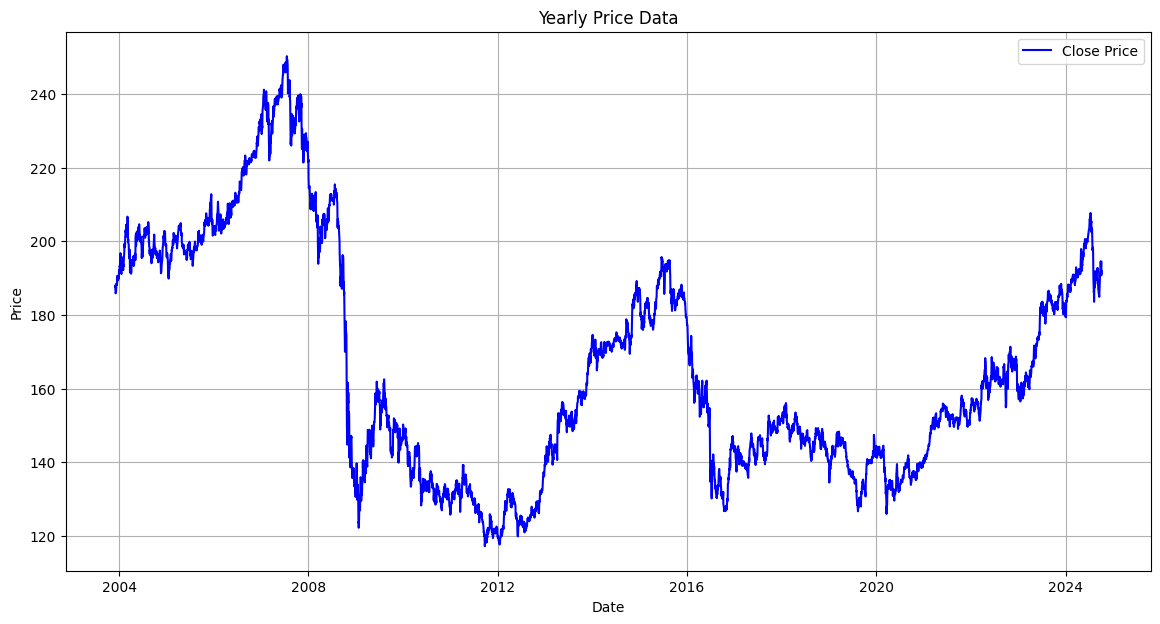

In [19]:
# Plot yearly data
plot_yearly_data(data)

**4..2. Plot out indicators vs price**

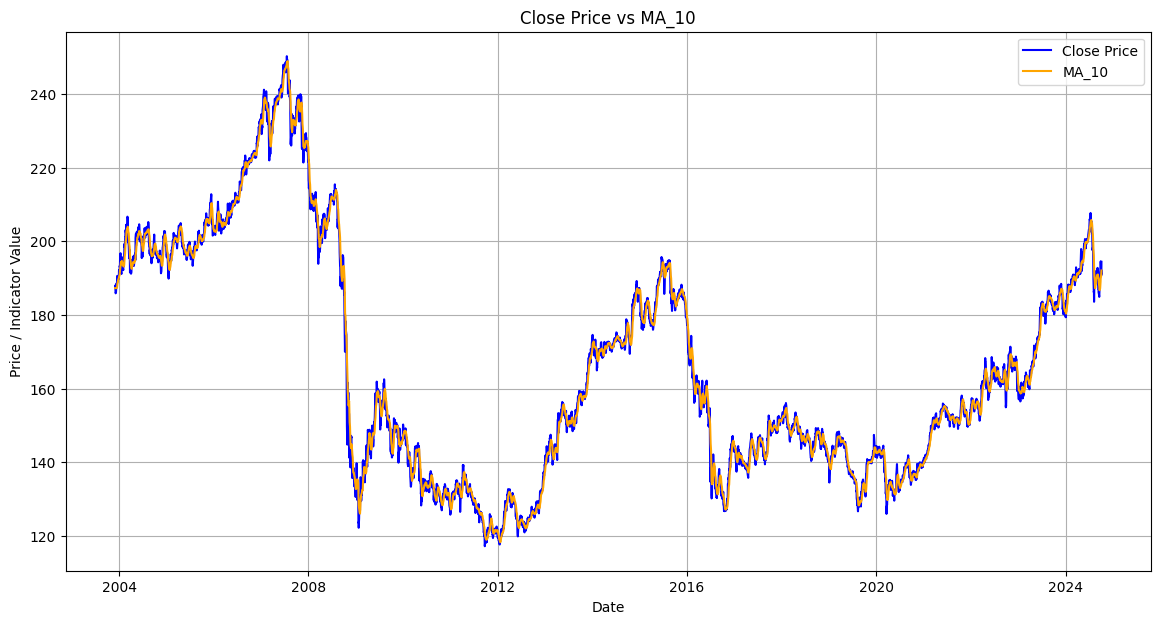

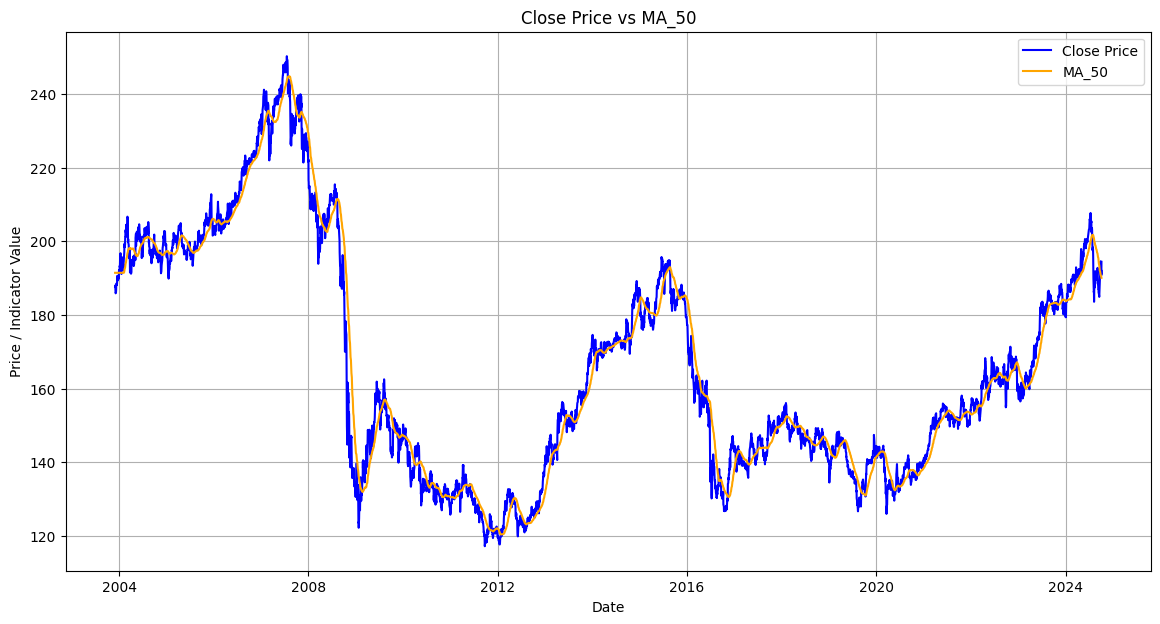

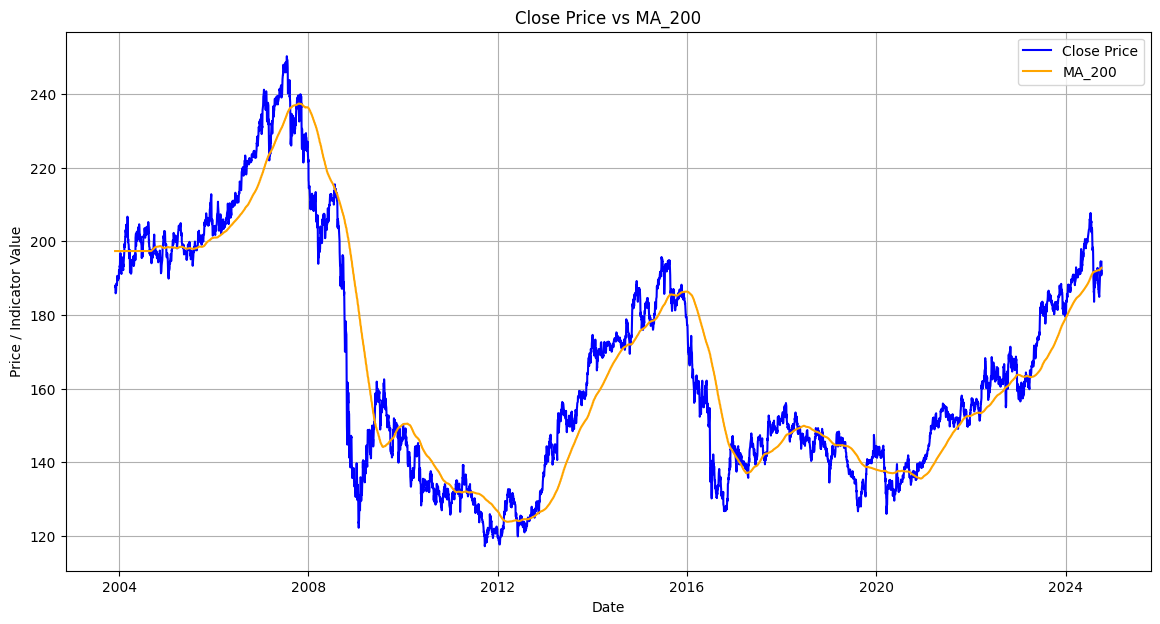

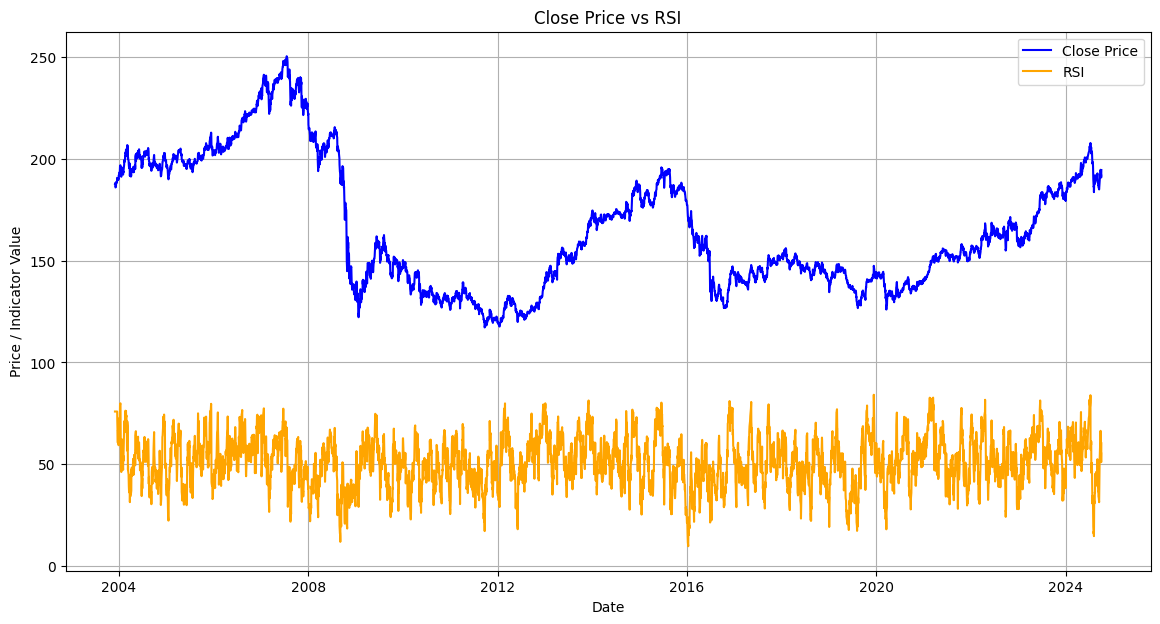

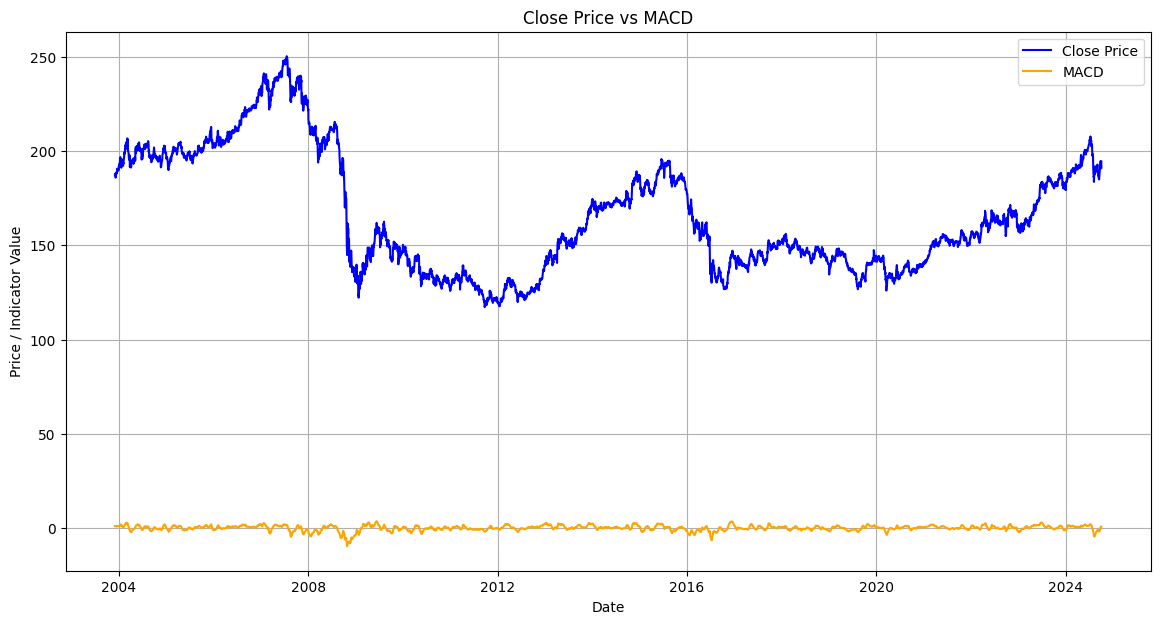

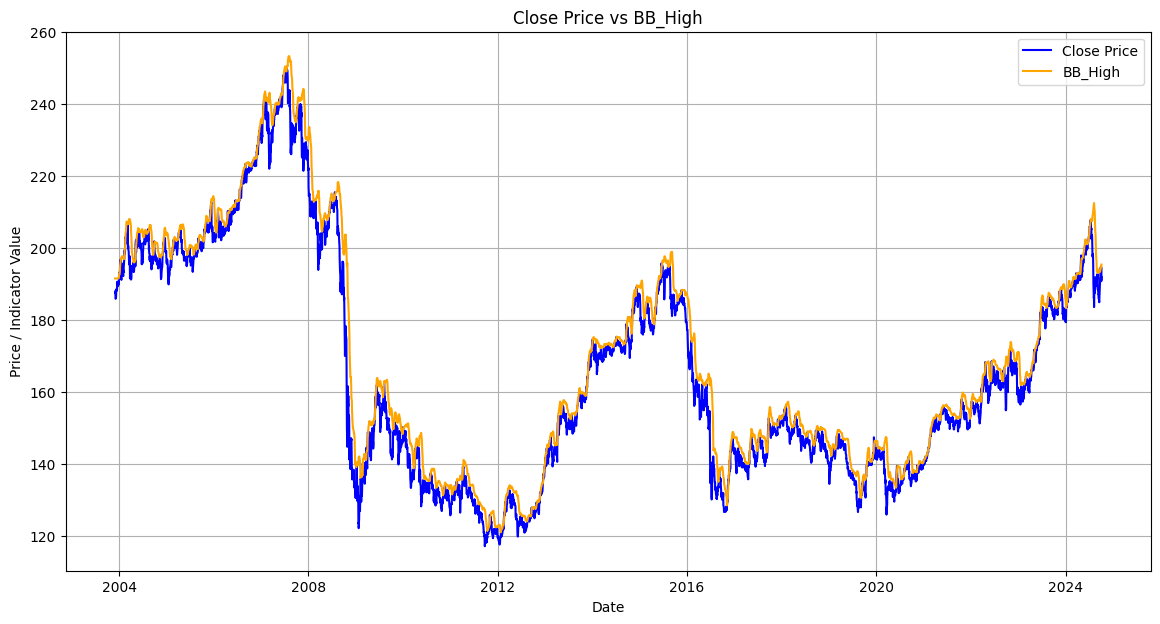

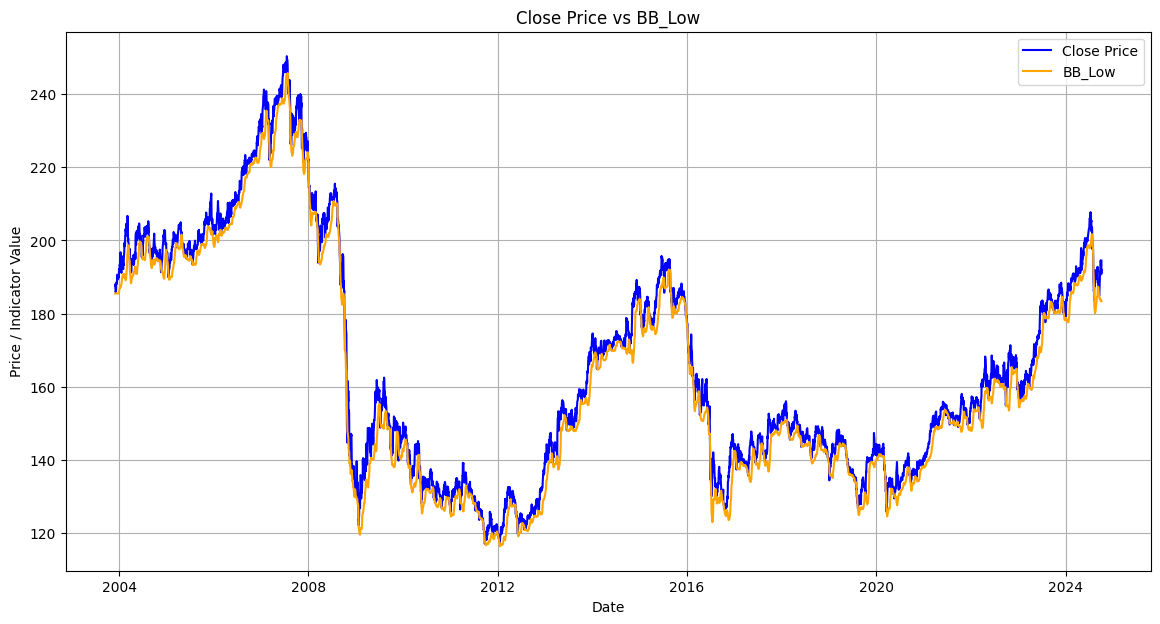

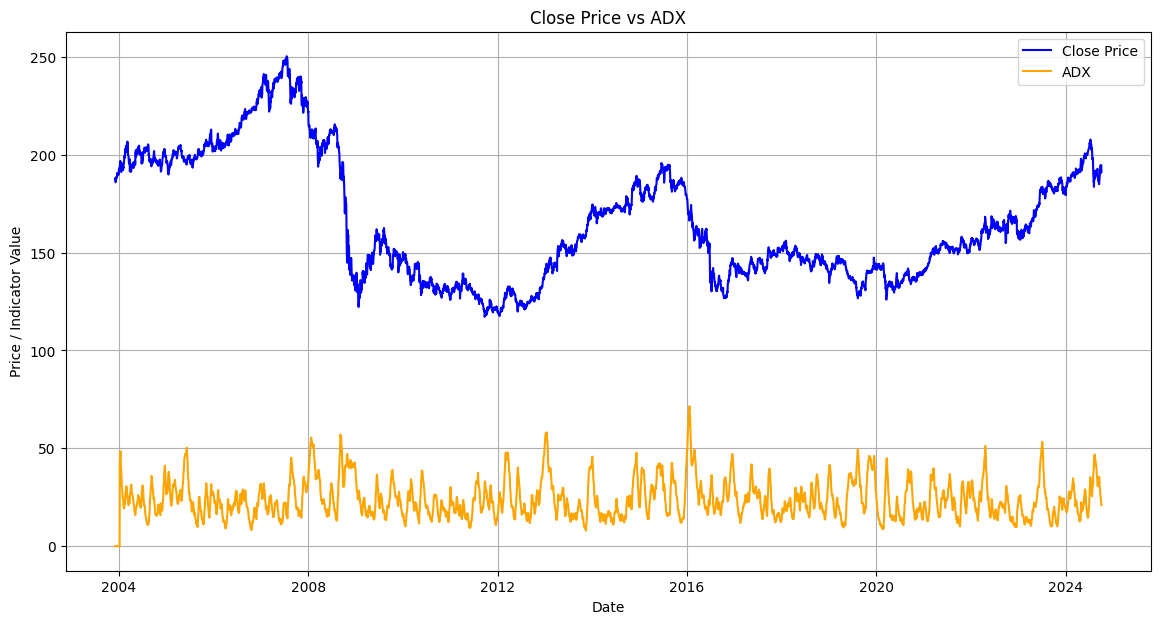

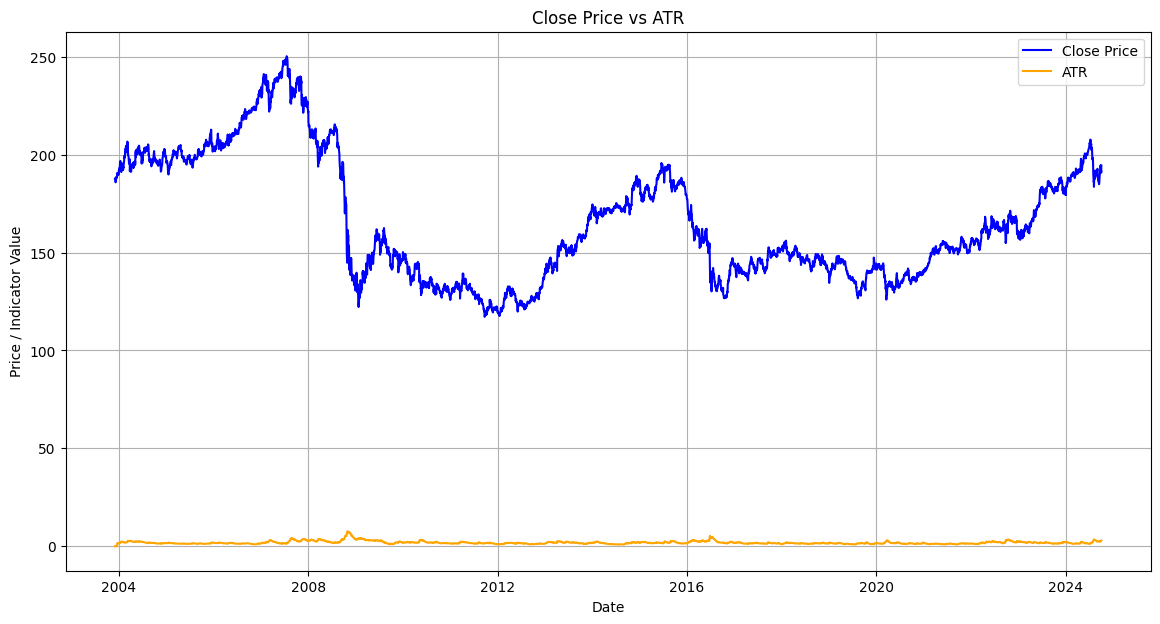

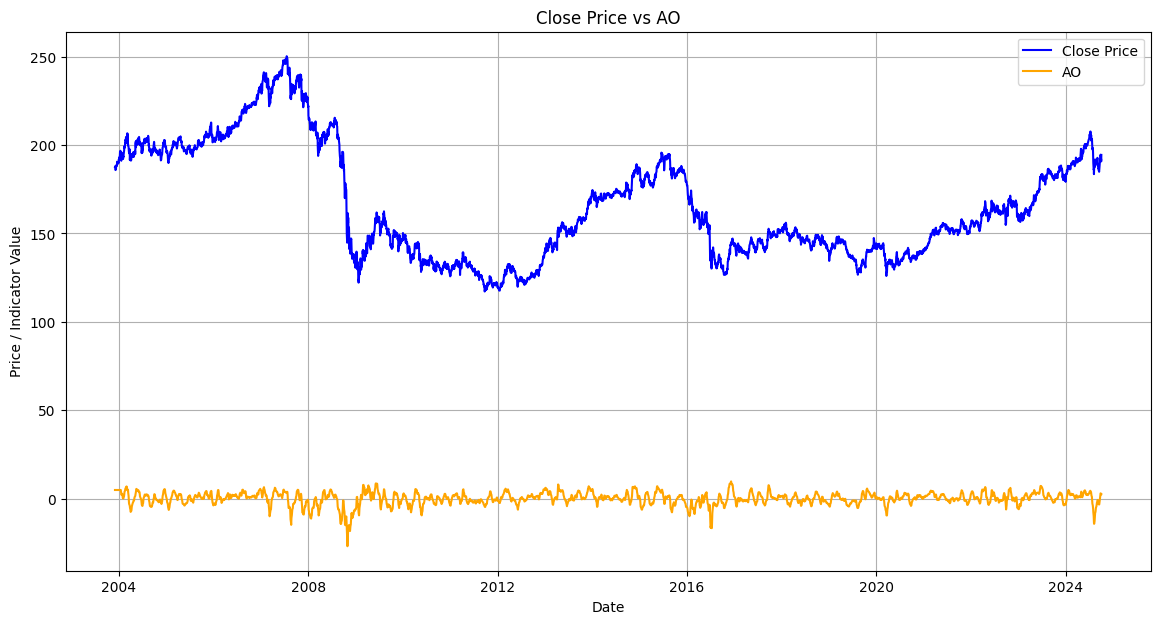

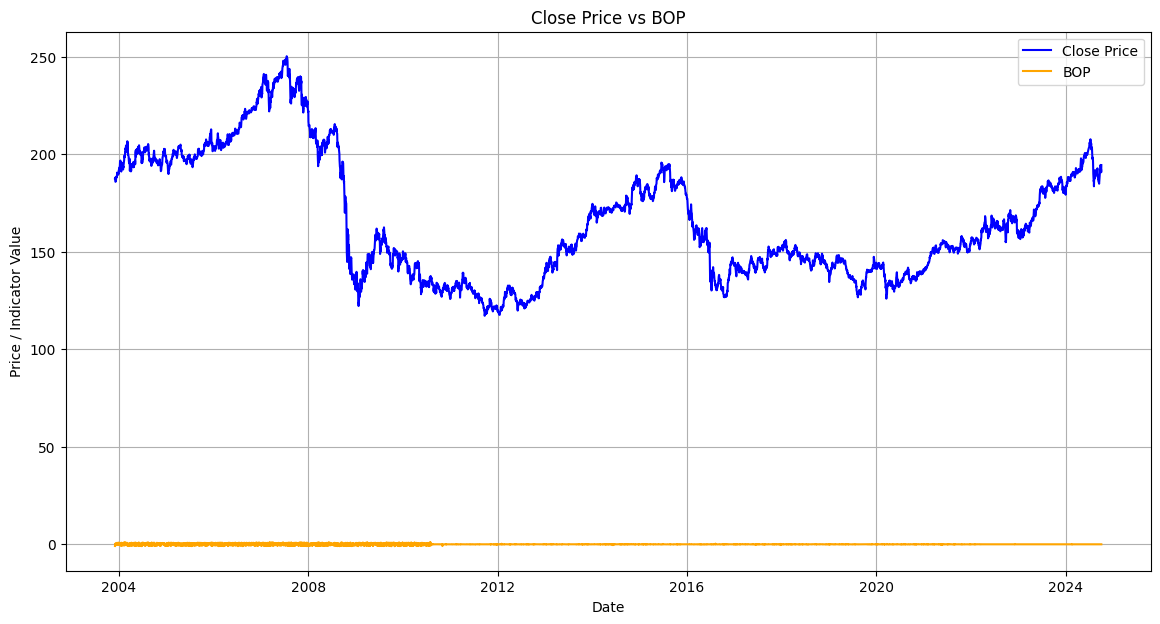

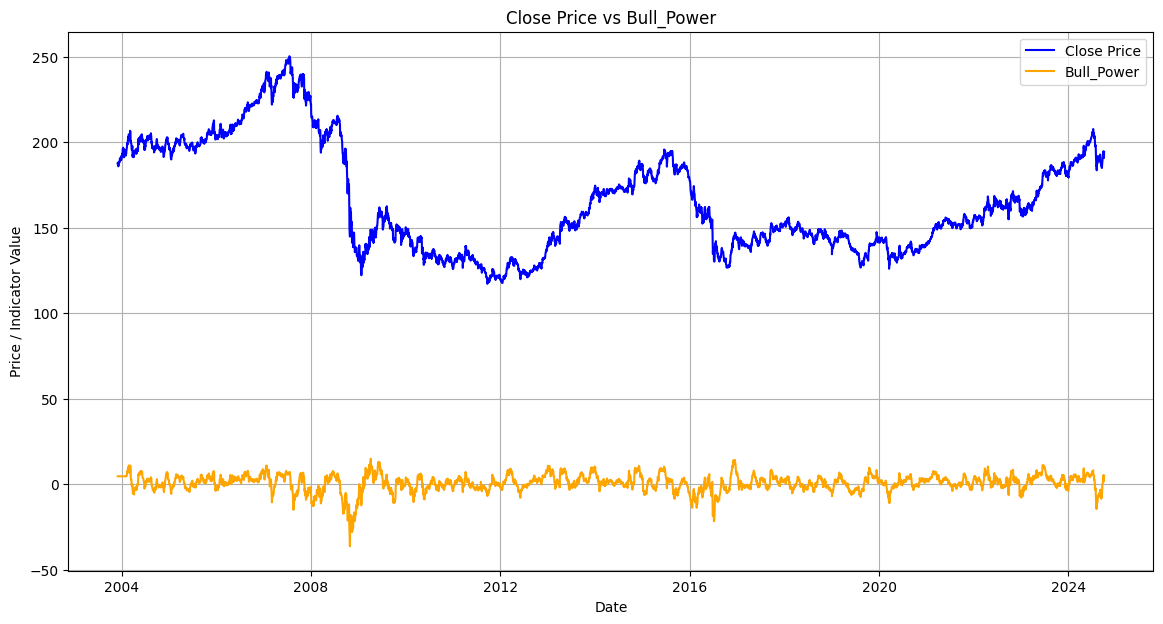

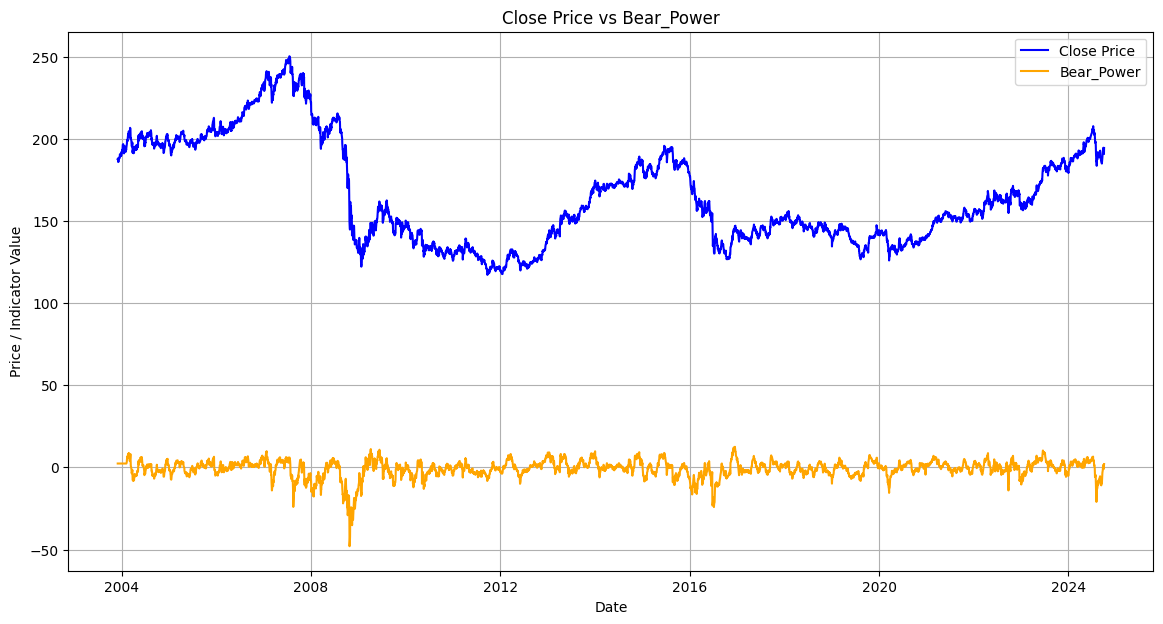

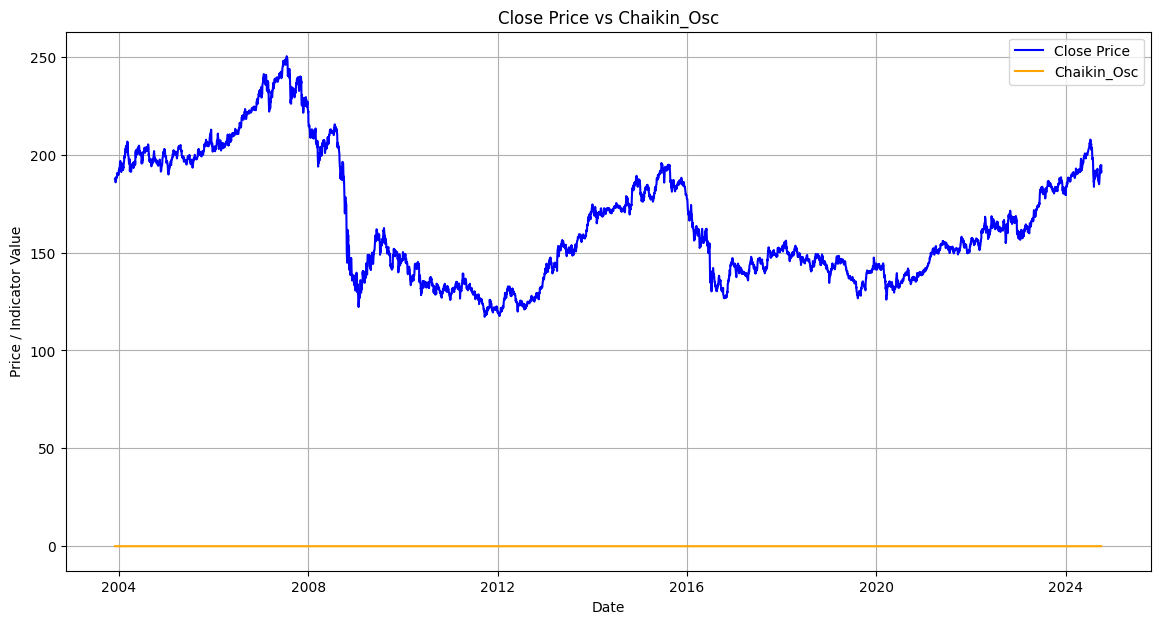

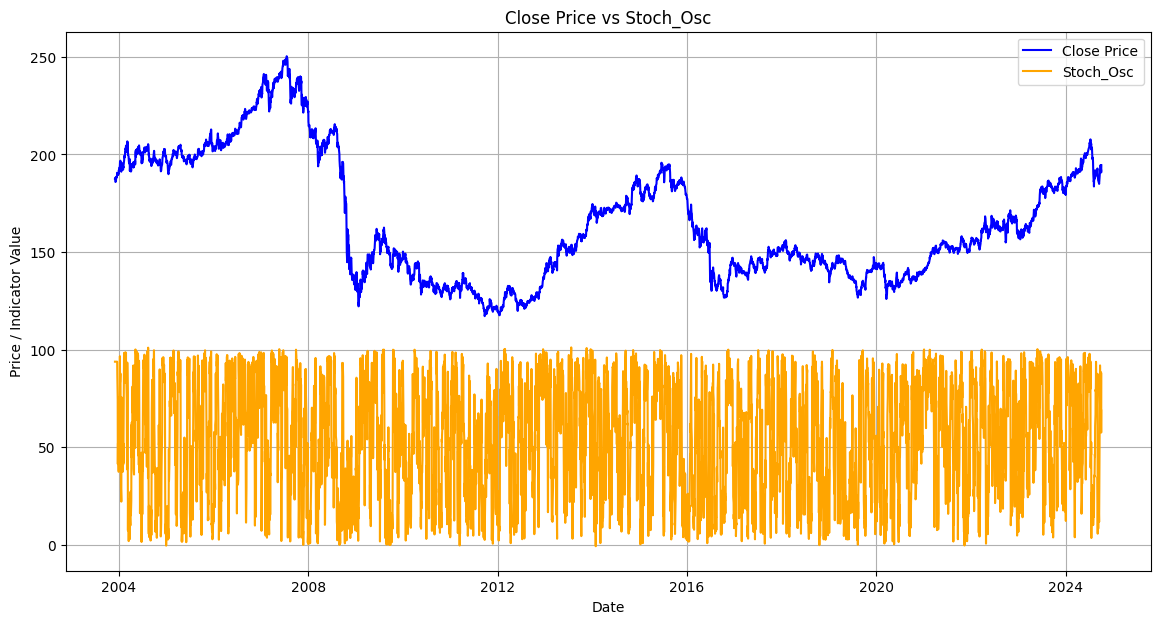

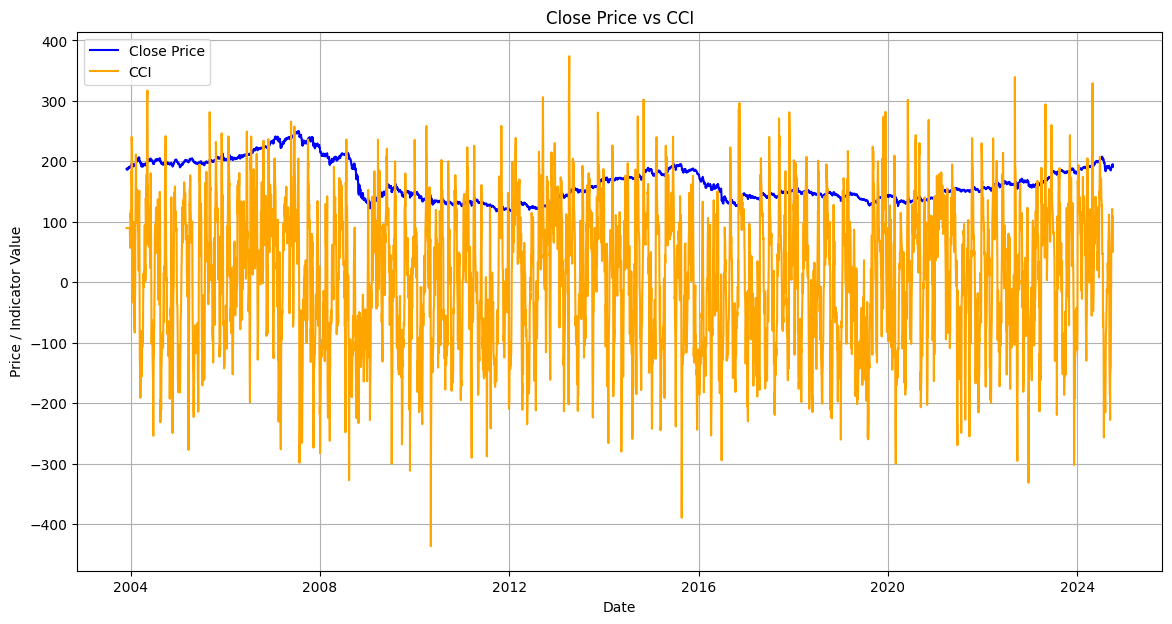

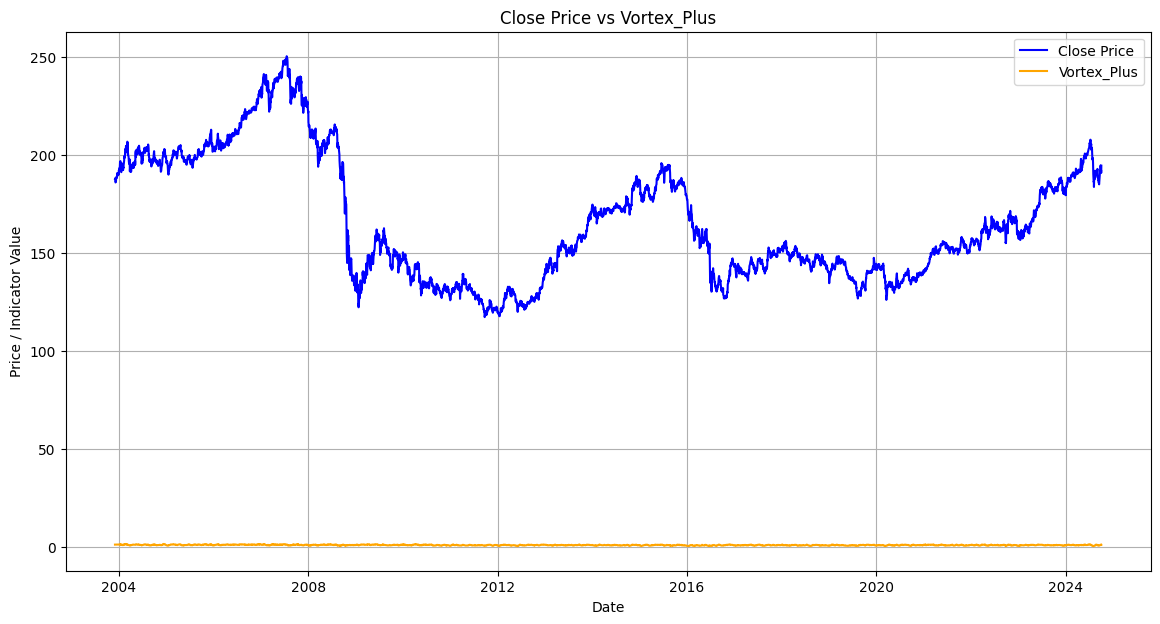

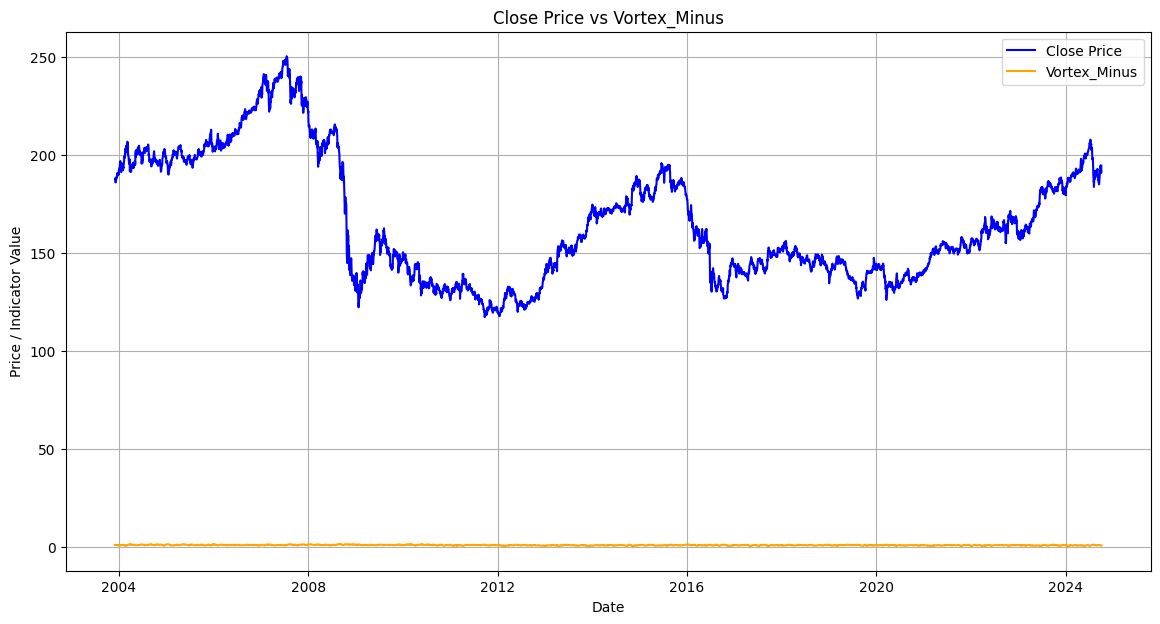

In [20]:
# Plot Close Price vs each indicator
for indicator in indicators:
    if indicator in data.columns:  # Check if the indicator exists
        plot_prices_vs_indicators(data, indicator, f'Close Price vs {indicator}')

# **STEP 5 FIND UN-RELATED FEATURES USING MUTUAL INFORMATION (MI)**

**5.1. Calculate MI and decide which feature has the highest correlation**

In [21]:
# Define the target variables
targets = ['Close', 'Open', 'High', 'Low']  # Add any other targets you want to consider

# Initialize a DataFrame to hold MI scores for each target
mi_results = pd.DataFrame()

# Separate features
X = data.drop(columns=['Date'] + targets)  # Exclude the target and date columns

# Calculate Mutual Information for each target variable
for target in targets:
    y = data[target]
    
    # Calculate Mutual Information
    mi_scores = mutual_info_regression(X, y)
    
    # Create a DataFrame for the current target's MI scores
    mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=[f'MI Score_{target}'])
    
    # Append to the results DataFrame
    mi_results = pd.concat([mi_results, mi_df], axis=1)

# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Display the MI scores for all targets
print("Mutual Information Scores for each target:")
print(mi_results)

Mutual Information Scores for each target:
              MI Score_Close  MI Score_Open  MI Score_High  MI Score_Low
Adj Close           7.316928       5.186020       3.904788      3.813426
Volume              0.000000       0.000002       0.000000      0.000000
MA_10               2.653415       2.713118       2.691625      2.632218
MA_50               2.109357       2.119166       2.192234      2.130592
MA_200              2.075759       2.085169       2.149449      2.095143
RSI                 0.208138       0.162504       0.164160      0.157373
MACD                0.384974       0.396747       0.384535      0.385460
BB_High             2.369163       2.405447       2.399557      2.372922
BB_Low              2.396441       2.423002       2.439167      2.363561
BB_Width            0.315306       0.305872       0.337679      0.309001
Volume_24h          0.000000       0.000000       0.000000      0.000070
ADL                 0.000007       0.000000       0.000000      0.000002
Aroon_Up

**5.2. Drop unrelated features**

In [22]:
# Define a threshold for MI score
mi_threshold = 0.25

# Identify features to drop based on the MI score for each target
features_to_drop = set()
for target in targets:
    low_mi_features = mi_results[mi_results[f'MI Score_{target}'] < mi_threshold].index.tolist()
    features_to_drop.update(low_mi_features)

# Drop the unrelated features from the DataFrame
X_reduced = X.drop(columns=list(features_to_drop))

# Optionally, update the DataFrame with the target
data_reduced = data.drop(columns=list(features_to_drop))

# Check the remaining features
print("Remaining features after dropping unrelated ones:")
print(X_reduced.columns)

# Save the reduced DataFrame if needed
reduced_file_path = os.path.join('Dataset', forex_label[0] + '_reduced_data.csv')
data_reduced.to_csv(reduced_file_path, index=False)
print(f"Saved reduced data to: {reduced_file_path}")
print(data.head(1000))

Remaining features after dropping unrelated ones:
Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'BB_High', 'BB_Low',
       'BB_Width', 'ATR', 'AO', 'BOP', 'Bull_Power', 'Bear_Power'],
      dtype='object')
Saved reduced data to: Dataset\GBPJPY=X_reduced_data.csv
          Date       Open       High        Low      Close  Adj Close  Volume  \
0   2003-12-01 189.330002 189.660004 187.740005 187.630005 187.630005       0   
1   2003-12-02 187.669998 188.809998 187.559998 188.009995 188.009995       0   
2   2003-12-03 188.020004 188.240005 186.490005 187.089996 187.089996       0   
3   2003-12-04 187.029999 187.029999 185.899994 186.220001 186.220001       0   
4   2003-12-05 186.190002 186.740005 185.830002 185.880005 185.880005       0   
..         ...        ...        ...        ...        ...        ...     ...   
995 2007-09-27 232.669998 234.449997 232.449997 234.130005 234.130005       0   
996 2007-09-28 234.080002 235.240005 232.479996 235.240005 235.240005       0 

# **STEP 6: PREPARE AND TRANSFORM DATA-FRAME**

In [23]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.feature_names].values

**6.1. Shift Label for future predictions**

In [24]:
k = -1
for target_column in targets:  # Iterate over each target
    data[target_column] = data[target_column].shift(k)

# Drop rows with NaN values created by the shift
data = data.dropna()

# Print some data 
print(data.head())

        Date       Open       High        Low      Close  Adj Close  Volume  \
0 2003-12-01 187.669998 188.809998 187.559998 188.009995 187.630005       0   
1 2003-12-02 188.020004 188.240005 186.490005 187.089996 188.009995       0   
2 2003-12-03 187.029999 187.029999 185.899994 186.220001 187.089996       0   
3 2003-12-04 186.190002 186.740005 185.830002 185.880005 186.220001       0   
4 2003-12-05 185.949997 186.699997 185.589996 186.179993 185.880005       0   

       MA_10      MA_50     MA_200  ...      ATR       AO       BOP  \
0 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.885416   
1 187.290999 191.452800 197.364300  ... 0.000000 4.871175  0.271997   
2 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.531433   
3 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.716809   
4 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.340655   

   Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc       CCI  Vortex_Plus  \
0    4.577199    2.357

**6.2. Split the data into training and test sets**

In [25]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Print out some information about the split
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
4340 training + 1085 test examples
           Date       Open       High        Low      Close  Adj Close  \
1406 2009-05-04 148.479996 149.800003 147.800003 149.080002 148.498993   
1467 2009-07-28 155.350006 155.570007 155.350006 155.460007 154.880005   
5106 2023-07-14 181.531006 182.119995 180.600998 181.531006 181.253006   
4507 2021-03-29 151.268997 151.927002 151.149994 151.287460 151.397995   

      Volume      MA_10      MA_50     MA_200  ...      ATR        AO  \
1406       0 144.200000 142.227200 156.297235  ... 2.981262  0.863727   
1467       0 154.984900 155.622719 144.142609  ... 2.402756 -0.207103   
5106       0 182.380200 176.571401 167.028041  ... 1.748016  1.923833   
4507       0 150.776031 147.119759 139.992386  ... 1.356005  0.856189   

          BOP  Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc        CCI  \
1406 0.005150    6.837802    5.092807     0.000000  88.053653  82.131167   
1467 0.290348   -0.60

**6.3. Define features and targets**

In [26]:
feature_columns = data.columns.difference(['Date'] + targets).tolist()  # Define features excluding Date and targets
X_reduced = data.drop(columns=['Date'] + targets).drop(columns=list(features_to_drop))  

In [27]:
X_train = train_set[X_reduced.columns]
X_test = test_set[X_reduced.columns]

# Split targets for each label
y_train_dict = {target: train_set[target] for target in targets}
y_test_dict = {target: test_set[target] for target in targets}

**6.4. Define and Train Model Pipelines for Each Target**

In [28]:

# Redefine num_feat_names based on X_reduced
num_feat_names = X_reduced.columns.tolist()

In [29]:
num_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])


**6.4.2. Fit and Transform the Pipeline on training data**

In [30]:

# Run the pipeline to process training data
processed_train_set_val = num_pipeline.fit_transform(X_train)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

# Convert the transformed data back to DataFrame with appropriate column names
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set

# Save the numerical pipeline
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')


____________ Processed feature values ____________
[[-0.5450361  -0.6841288  -0.75221476 -0.30702506  0.62526504 -0.59088895
  -0.68403152  0.6686439   1.50141294  0.22968533 -0.02357137  1.23594487
   1.10661301]
 [-0.33958551 -0.33625649 -0.3181753  -0.71046588  0.03123593 -0.321091
  -0.39892442  0.51592723  0.7411582  -0.06438511  0.91906131 -0.28354755
  -0.02229692]
 [ 0.50955076  0.54739257  0.36060048  0.04915583  0.95994572  0.48248257
   0.60172458 -0.75160162 -0.11928175  0.52081112 -0.04059444  0.99981249
   0.84122698]]
(4340, 13)


['models/num_pipeline.pkl']

# **STEP 7. TRAIN AND EVALUATE MODEL**

**Function to calculate R2 score and Root Mean Squared Error.**

In [31]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [32]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**7.1. Try Light GBM model.**

In [33]:
for target in targets:
    model = lgb.LGBMRegressor()  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ LGBMRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4340, number of used features: 13
[LightGBM] [Info] Start training from score 165.434288

____________ LGBMRegressor for Close ____________

R2 score (on training data, best=1): 0.9991764287257346
Root Mean Square Error:  0.8906586077558083

Predictions:  [236.35789866 149.23955574 169.61091925 149.29319589 159.48759126
 144.6351631  162.11820325 149.74720352 240.567037  ]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as LGB

**7.2. Try XGBoost model.**

In [34]:
for target in targets:
    model = XGBRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ XGBoost_Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ XGBoost_Regressor for Close ____________

R2 score (on training data, best=1): 0.9997965497201452
Root Mean Square Error:  0.4426799173188867

Predictions:  [237.86548 148.99457 169.04839 149.26668 158.63182 144.40158 162.09807
 149.32689 239.73747]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as XGBRegressor_model.pkl

____________ XGBoost_Regressor for Open ____________

R2 score (on training data, best=1): 0.9998919320655646
Root Mean Square Error:  0.322782380877334

Predictions:  [238.29488 149.2854  169.62872 149.56328 158.69475 144.54022 161.3564
 149.71565 240.26169]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.72000122070312, 241.02699279785156]
Model successfully saved as XGBRegres

**7.3. Try Decision Tree (in-lecture).**

In [35]:
for target in targets:
    model = DecisionTreeRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ DecisionTreeRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ DecisionTreeRegressor for Close ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [237.55999756 149.01899719 172.86099243 149.52999878 157.80999756
 146.47000122 161.05999756 149.86999512 241.82299805]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as DecisionTreeRegressor_model.pkl

____________ DecisionTreeRegressor for Open ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [237.25       149.59199524 169.46000671 149.49000549 158.30999756
 143.33299255 160.26300049 149.86999512 240.16999817]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.72000122070312, 241.02699279785156]
Model successfully saved

**7.4. Try Polynomial Regression (in-lecture).**

In [36]:
for target in targets:
    degree = 2  # Degree of the polynomial
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Fit the model on the respective target
    model.fit(X_train, y_train_dict[target])

    print(f'\n____________ PolynomialRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    predictions = model.predict(X_test[:9]).round(decimals=1)
    print("\nPredictions: ", predictions)
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ PolynomialRegressor for Close ____________

R2 score (on training data, best=1): 0.9989275710876823
Root Mean Square Error:  1.016353837555187

Predictions:  [237.1 147.6 169.6 149.3 159.4 144.1 163.6 148.9 240.9]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for Open ____________

R2 score (on training data, best=1): 0.9996608594047148
Root Mean Square Error:  0.5718093920466932

Predictions:  [237.4 147.6 169.9 149.3 159.4 144.  163.6 149.3 240.9]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.72000122070312, 241.02699279785156]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for High ____________

R2 sco

**7.5. Try Linear Regressor (in-lecture).**

In [37]:
for target in targets:
    model = LinearRegression() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Linear Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Linear Regressor for Close ____________

R2 score (on training data, best=1): 0.9986350834137316
Root Mean Square Error:  1.1466047326556512

Predictions:  [237.78689601 148.37138095 169.73474237 149.41454636 159.23192097
 144.12338216 162.3064669  149.36030314 241.15799967]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as LinearRegression_model.pkl

____________ Linear Regressor for Open ____________

R2 score (on training data, best=1): 0.9994679159600235
Root Mean Square Error:  0.7162283567738839

Predictions:  [237.78291929 148.3437464  169.74354347 149.44366342 159.2068587
 144.10276836 162.4031739  149.49423443 241.00815208]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.72000122070312, 

**7.6. Try Random Forest (in-lecture).**

In [38]:
for target in targets:
    model = RandomForestRegressor(n_estimators=20) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ RandomForestRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ RandomForestRegressor for Close ____________

R2 score (on training data, best=1): 0.9997153885207076
Root Mean Square Error:  0.5235846196990556

Predictions:  [237.3855011  149.3099762  170.39544907 149.38595047 158.79894867
 144.56814957 160.96544952 149.71155014 241.068396  ]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as RandomForestRegressor_model.pkl

____________ RandomForestRegressor for Open ____________

R2 score (on training data, best=1): 0.9998522578388028
Root Mean Square Error:  0.3774101876859691

Predictions:  [237.17000198 149.35539856 170.49380112 149.69685135 159.12229919
 144.72805176 161.33544922 149.80565033 241.06210022]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.

**7.7. Try K-Nearest-Neighbor**

In [39]:
for target in targets:
    model = KNeighborsRegressor(n_neighbors=5) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ KNeighborRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ KNeighborRegressor for Close ____________

R2 score (on training data, best=1): 0.9972904282727522
Root Mean Square Error:  1.6155150208939804

Predictions:  [243.38599854 148.93359985 164.65300293 149.61560059 161.1769989
 143.56520081 161.90179749 147.94779663 241.66159668]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as KNeighborsRegressor_model.pkl

____________ KNeighborRegressor for Open ____________

R2 score (on training data, best=1): 0.9976616959122946
Root Mean Square Error:  1.5014535108749434

Predictions:  [242.90679932 148.92359924 164.66619873 149.62520142 161.20299988
 143.55400085 161.90179749 147.83979797 241.07200012]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.720001220

**7.8. Try using SVR**

In [40]:
for target in targets:
    model = SVR(kernel='rbf')  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Support Vector Regressor (SVR) for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Support Vector Regressor (SVR) for Close ____________

R2 score (on training data, best=1): 0.9854582867462249
Root Mean Square Error:  3.7425573377743335

Predictions:  [226.28958295 147.91467457 168.95375912 149.45760572 159.51113999
 143.19227716 161.24809283 150.46565565 236.33279414]
Labels:       [238.14999389648438, 146.66600036621094, 169.66900634765625, 149.38699340820312, 158.11000061035156, 143.61700439453125, 162.01199340820312, 149.47000122070312, 241.80999755859375]
Model successfully saved as SVR_model.pkl

____________ Support Vector Regressor (SVR) for Open ____________

R2 score (on training data, best=1): 0.9859081663218864
Root Mean Square Error:  3.685913589963932

Predictions:  [226.80434418 147.88021936 169.12244543 149.47628027 159.48853528
 143.21722961 161.27121487 150.47538703 235.8080693 ]
Labels:       [237.22999572753906, 146.65899658203125, 169.6699981689453, 149.3939971923828, 158.3000030517578, 143.61199951171875, 162.01199340820312, 149.7

# **STEP 8: EVALUATE WITH K-CROSS VALIDATION:**


____________ K-fold cross validation ____________

Evaluating LinearRegression for Close...
Close - LinearRegression rmse:  [1.20774271 1.20196663 1.2505062  1.0371712  1.11295072]
Close - Avg. rmse:  1.1620674926278738 



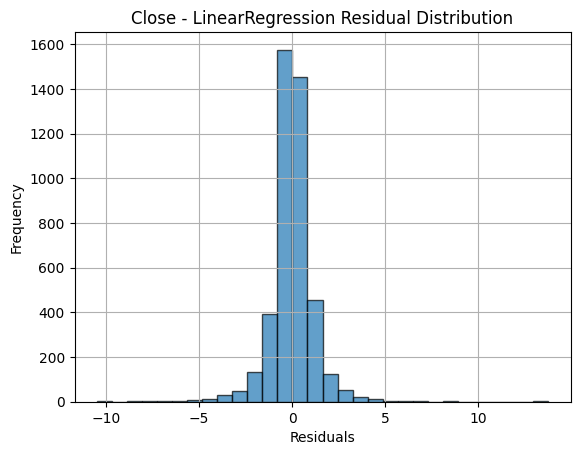


Evaluating LinearRegression for Open...
Open - LinearRegression rmse:  [0.71299294 0.72860626 0.73011162 0.72279227 0.7101384 ]
Open - Avg. rmse:  0.720928298624775 



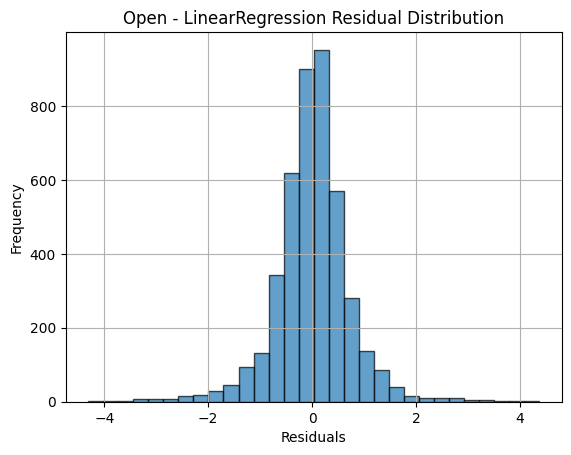


Evaluating LinearRegression for High...
High - LinearRegression rmse:  [0.97894928 1.04389501 1.04519698 0.9814314  0.99766143]
High - Avg. rmse:  1.0094268182882962 



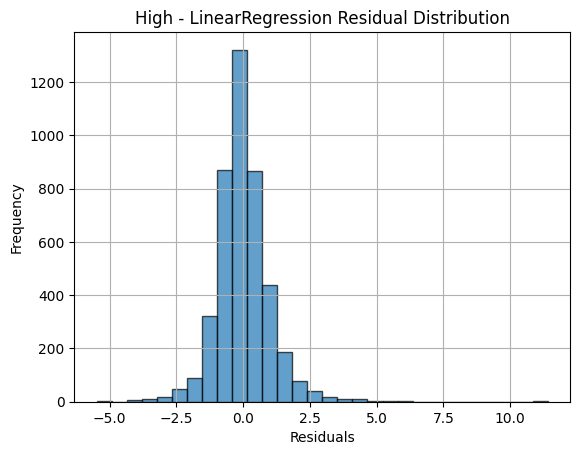


Evaluating LinearRegression for Low...
Low - LinearRegression rmse:  [1.38883174 1.14211035 1.18780383 1.14897006 1.0611459 ]
Low - Avg. rmse:  1.18577237904548 



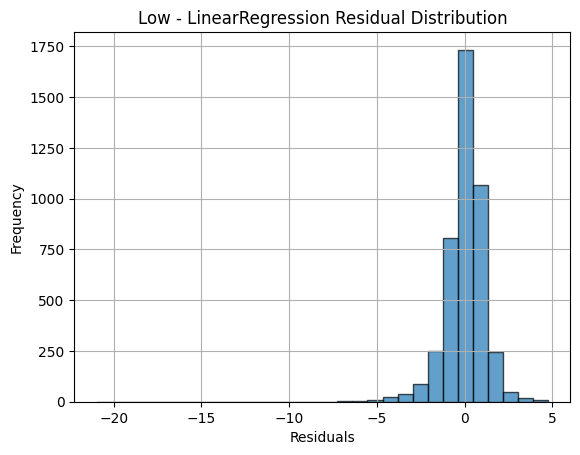


Evaluating LGBMRegressor for Close...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 165.327069
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 165.787226
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col

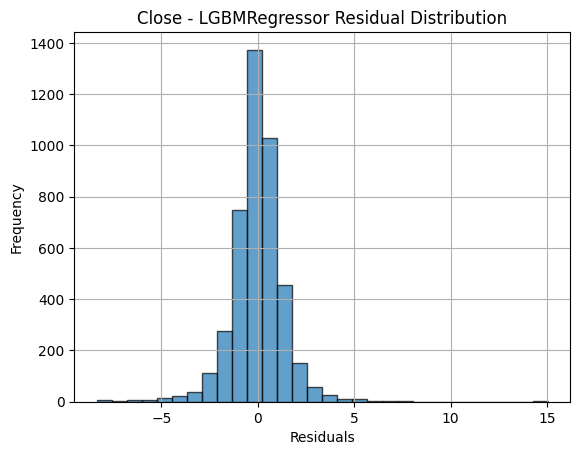


Evaluating LGBMRegressor for Open...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 165.317810
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 165.793326
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-

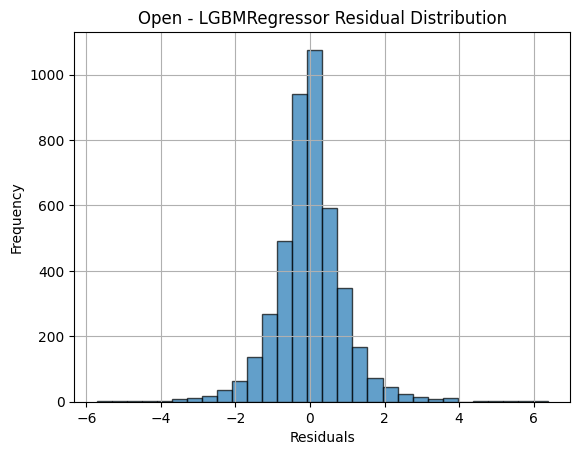


Evaluating LGBMRegressor for High...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 166.067980
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 166.533811
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-

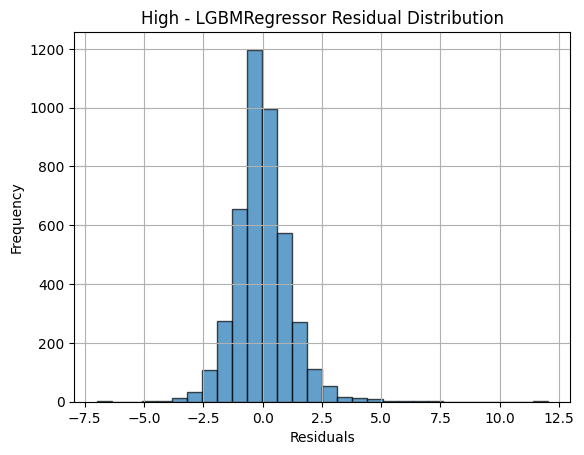


Evaluating LGBMRegressor for Low...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 164.504270
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 13
[LightGBM] [Info] Start training from score 164.969782
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-w

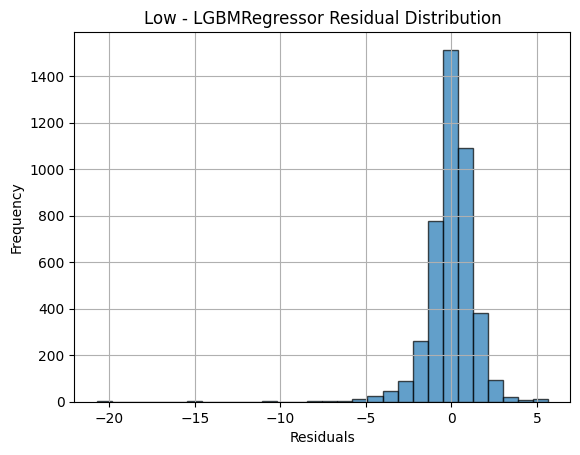


Evaluating XGBoost for Close...
Close - XGBoost rmse:  [1.49538829 1.40434863 1.42219515 1.37377312 1.3684869 ]
Close - Avg. rmse:  1.4128384165171892 



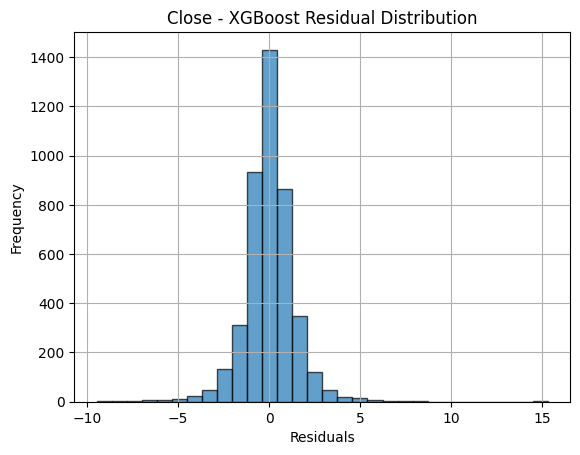


Evaluating XGBoost for Open...
Open - XGBoost rmse:  [0.9670105  1.00150366 0.94787432 0.99151507 0.94221388]
Open - Avg. rmse:  0.9700234870618759 



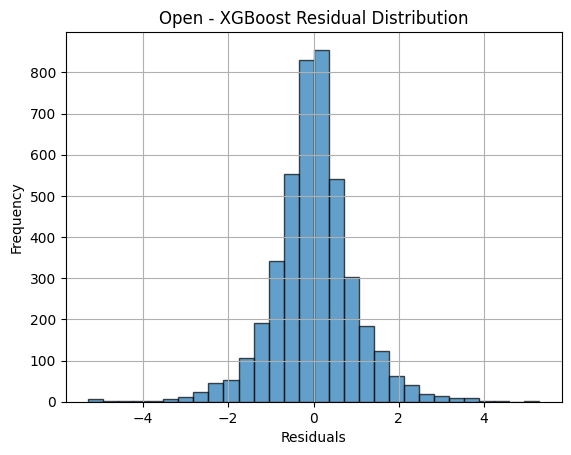


Evaluating XGBoost for High...
High - XGBoost rmse:  [1.22141515 1.25592165 1.24754668 1.24509632 1.18177095]
High - Avg. rmse:  1.230350148069595 



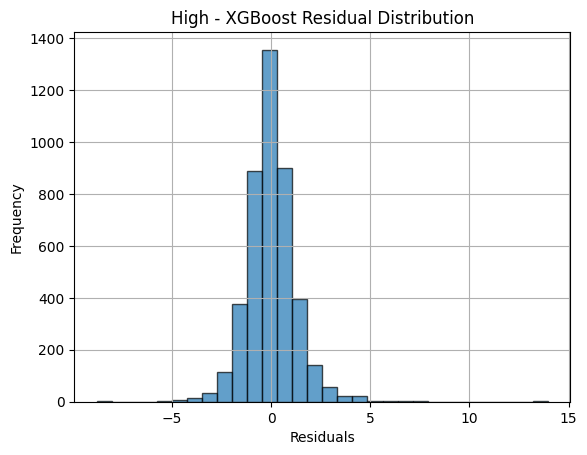


Evaluating XGBoost for Low...
Low - XGBoost rmse:  [1.56203889 1.39460897 1.3624903  1.3880595  1.2633015 ]
Low - Avg. rmse:  1.394099831268955 



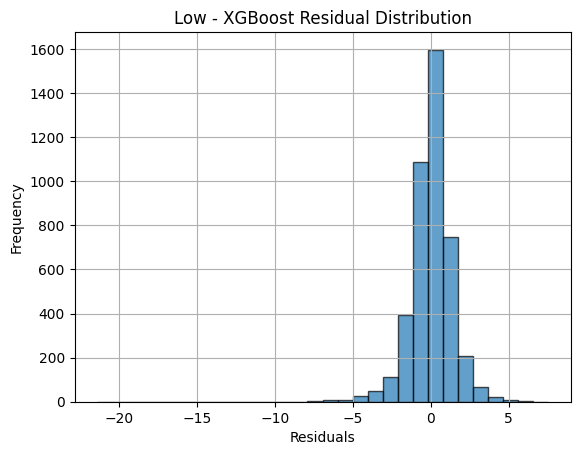


Evaluating DecisionTreeRegressor for Close...
Close - DecisionTreeRegressor rmse:  [1.72238887 1.69391871 1.71094077 1.65066292 1.74431463]
Close - Avg. rmse:  1.7044451820550017 



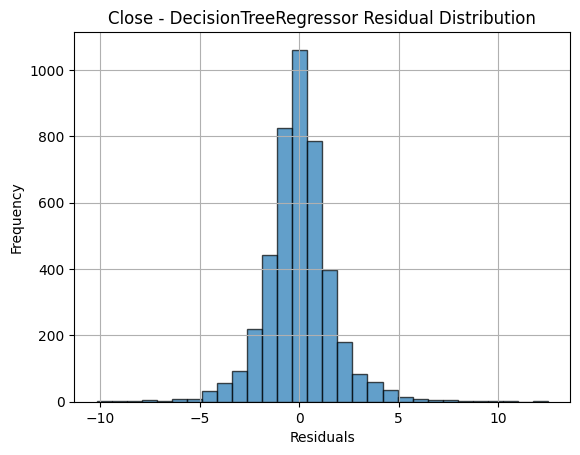


Evaluating DecisionTreeRegressor for Open...
Open - DecisionTreeRegressor rmse:  [1.25144234 1.22788822 1.24352744 1.18086494 1.21737012]
Open - Avg. rmse:  1.224218612173708 



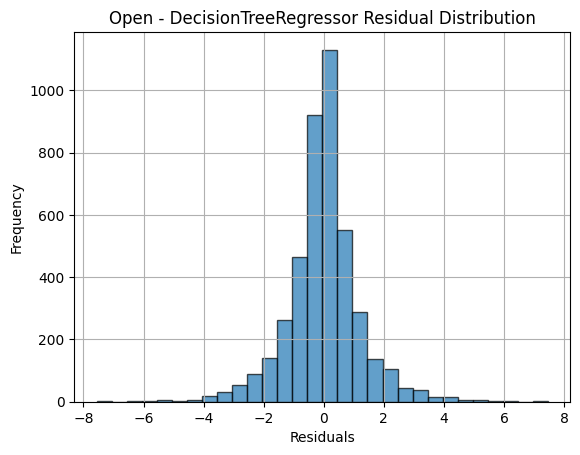


Evaluating DecisionTreeRegressor for High...
High - DecisionTreeRegressor rmse:  [1.49835265 1.43048029 1.6319498  1.48596698 1.48828087]
High - Avg. rmse:  1.5070061179141523 



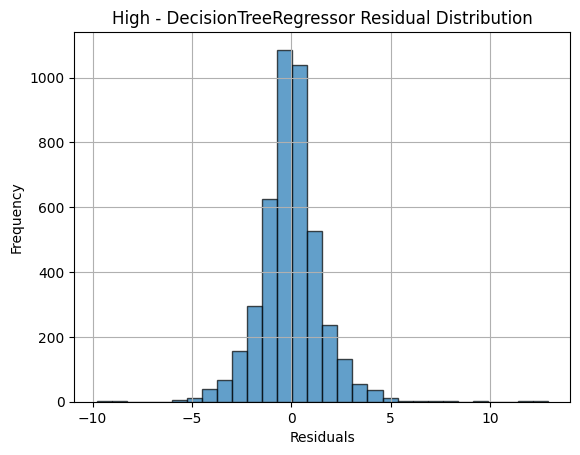


Evaluating DecisionTreeRegressor for Low...
Low - DecisionTreeRegressor rmse:  [1.83202044 1.63709966 1.7175659  1.87210939 1.93513193]
Low - Avg. rmse:  1.7987854639443075 



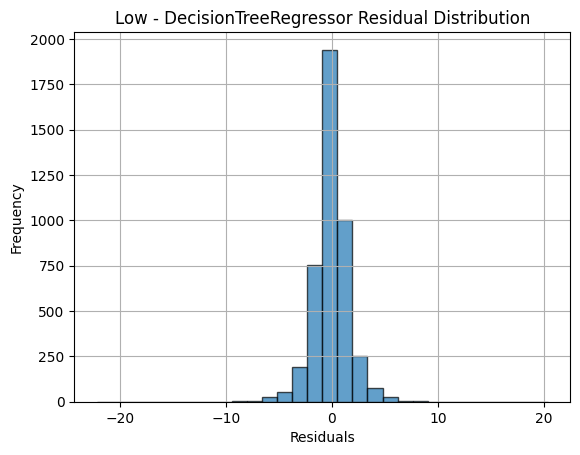


Evaluating RandomForestRegressor for Close...
Close - RandomForestRegressor rmse:  [1.39595693 1.3109759  1.39536739 1.29241563 1.34777691]
Close - Avg. rmse:  1.3484985518380908 



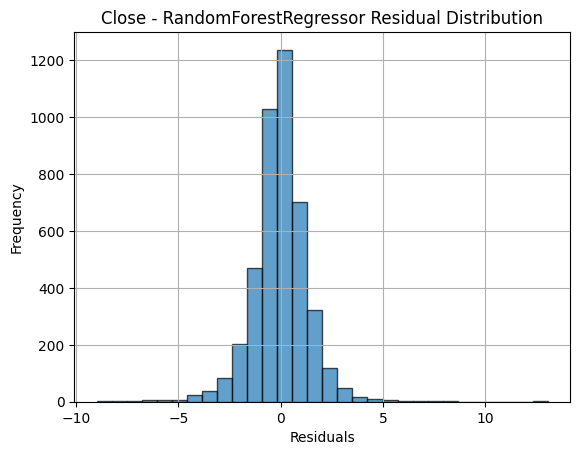


Evaluating RandomForestRegressor for Open...
Open - RandomForestRegressor rmse:  [0.95381981 0.96066428 0.97683797 1.00450393 0.98411469]
Open - Avg. rmse:  0.9759881343161493 



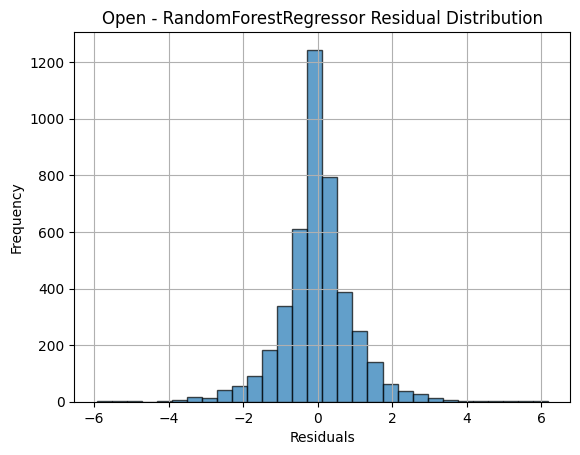


Evaluating RandomForestRegressor for High...
High - RandomForestRegressor rmse:  [1.14139873 1.1716768  1.22069953 1.21179656 1.21781274]
High - Avg. rmse:  1.1926768730877524 



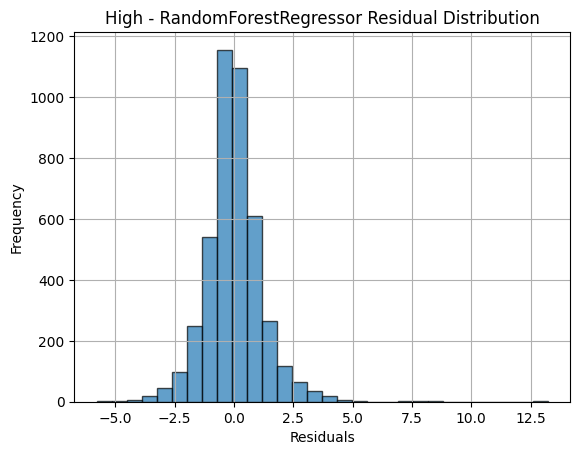


Evaluating RandomForestRegressor for Low...
Low - RandomForestRegressor rmse:  [1.50813794 1.30693407 1.37178831 1.32812635 1.25342428]
Low - Avg. rmse:  1.3536821887550687 



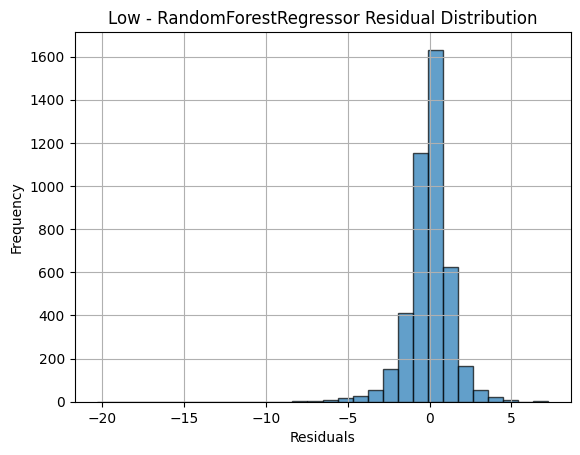


Evaluating KNeighborsRegressor for Close...
Close - KNeighborsRegressor rmse:  [2.28037992 2.30985213 2.14201236 2.06280855 2.31616858]
Close - Avg. rmse:  2.222244308344042 



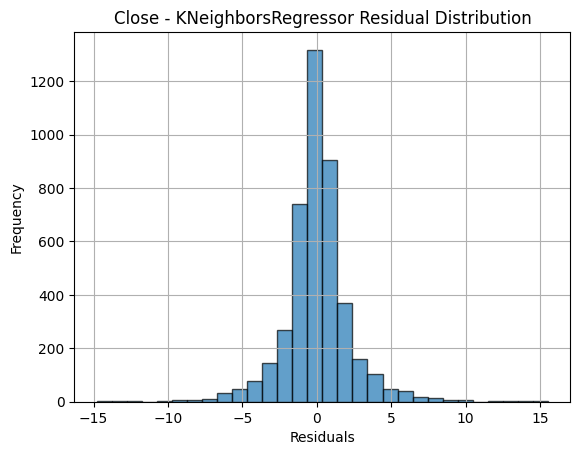


Evaluating KNeighborsRegressor for Open...
Open - KNeighborsRegressor rmse:  [2.12890872 2.12948164 1.99116281 2.03004778 2.19969511]
Open - Avg. rmse:  2.0958592102222835 



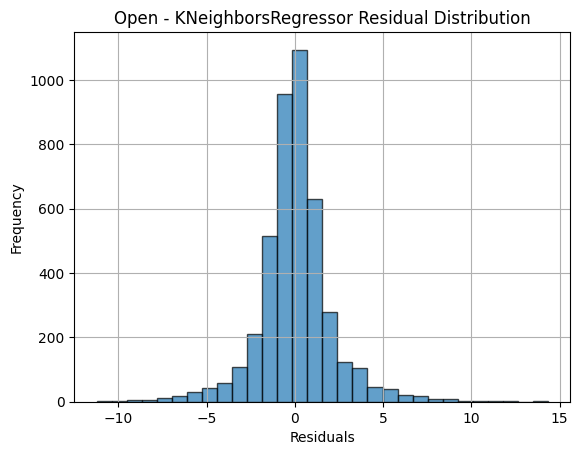


Evaluating KNeighborsRegressor for High...
High - KNeighborsRegressor rmse:  [2.22155618 2.23889386 2.03617519 2.05991831 2.21735962]
High - Avg. rmse:  2.154780631503634 



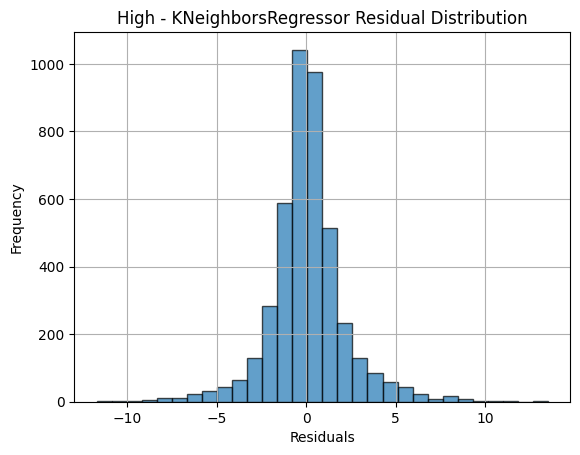


Evaluating KNeighborsRegressor for Low...
Low - KNeighborsRegressor rmse:  [2.36105468 2.28118598 2.16058068 2.1318717  2.30149552]
Low - Avg. rmse:  2.247237710746386 



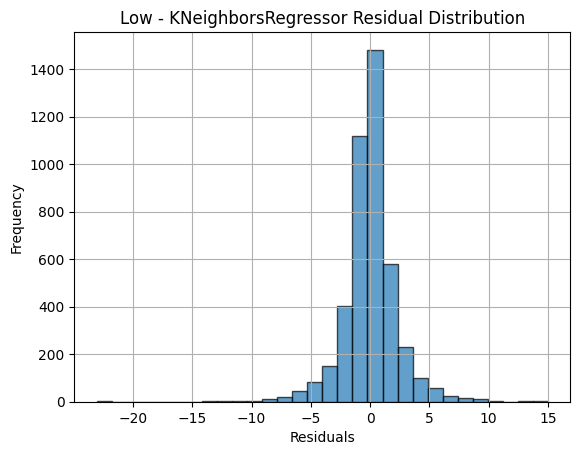


Evaluating SVR for Close...
Close - SVR rmse:  [4.6634748  4.78918409 4.61144177 4.48488261 3.96095226]
Close - Avg. rmse:  4.501987105988553 



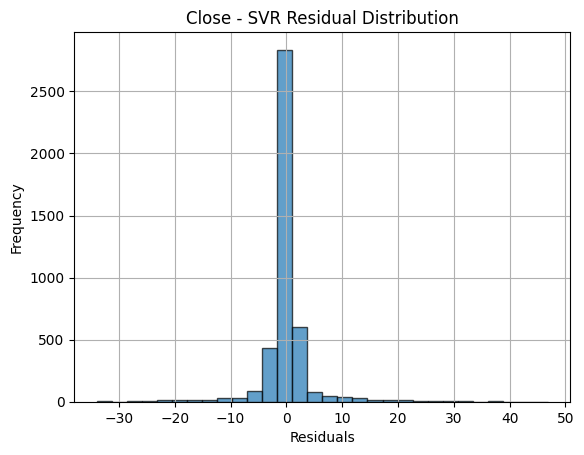


Evaluating SVR for Open...
Open - SVR rmse:  [4.54052249 4.63404537 4.55252122 4.46957386 3.8110597 ]
Open - Avg. rmse:  4.401544528574852 



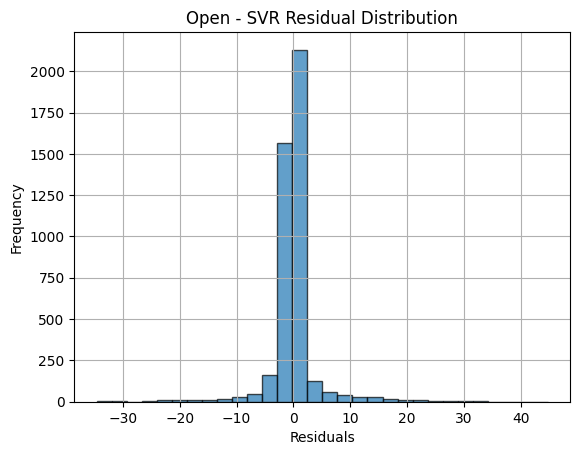


Evaluating SVR for High...
High - SVR rmse:  [4.55235399 4.70269478 4.54689349 4.40658442 3.90932661]
High - Avg. rmse:  4.423570658933061 



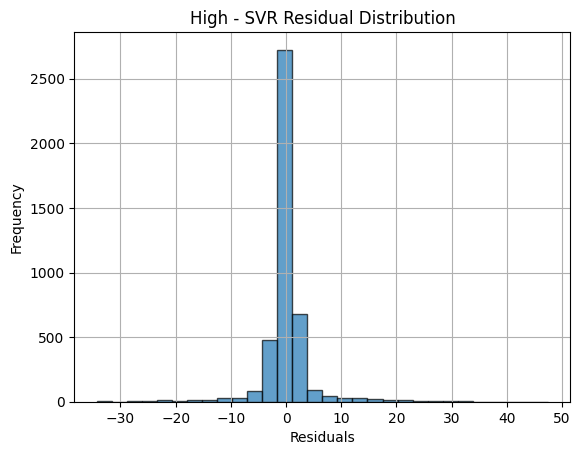


Evaluating SVR for Low...
Low - SVR rmse:  [4.68276431 4.76725627 4.66997155 4.59879842 3.93305494]
Low - Avg. rmse:  4.530369100799472 



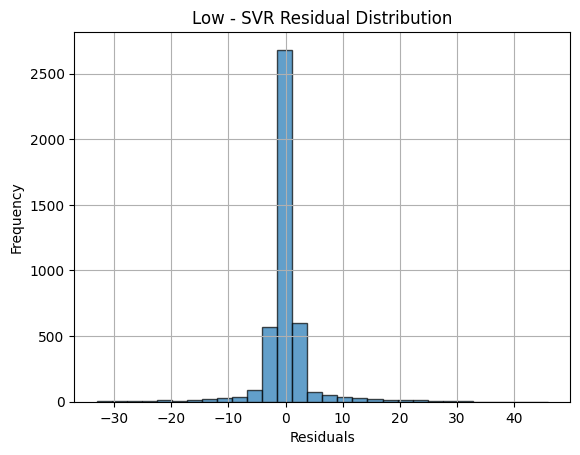

In [46]:
# Ensure directories exist
os.makedirs('saved_objects', exist_ok=True)
os.makedirs('models', exist_ok=True)

print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5, shuffle=True, random_state=37)  # cv data generator

run_new_evaluation = 1  # Set to 1 for new evaluation; 0 to load results
filename_prefix = "your_prefix"  # Change this to your desired prefix

if run_new_evaluation:
    models = {
        "LinearRegression": LinearRegression(),
        "LGBMRegressor": lgb.LGBMRegressor(),
        "XGBoost": XGBRegressor(),
        "DecisionTreeRegressor": DecisionTreeRegressor(),
        "RandomForestRegressor": RandomForestRegressor(n_estimators=20),
        "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
        "SVR": SVR(kernel='rbf')
    }
    
    for model_name, model in models.items():
        for target in targets:
            print(f"\nEvaluating {model_name} for {target}...")
            y_train = y_train_dict[target]
            
            try:
                nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
                rmse_scores = np.sqrt(-nmse_scores)
                
                # Save RMSE scores
                joblib.dump(rmse_scores, f'saved_objects/{model_name}_rmse_{target}.pkl')
                print(f"{target} - {model_name} rmse: ", rmse_scores)
                print(f"{target} - Avg. rmse: ", mean(rmse_scores), '\n')

                # Predict using cross-validation
                y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
                
                # Calculate residuals
                residuals = y_train - y_train_pred
                
                # Plot the residual distribution
                plt.figure()
                plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
                plt.title(f'{target} - {model_name} Residual Distribution')
                plt.xlabel('Residuals')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.savefig(f'models/{filename_prefix}_{target}_{model_name}_residuals_plot.png')  # Save with target name
                plt.show()  # Display the plot (useful in Jupyter Notebooks)
                plt.close()  # Close the plot to free memory
            except Exception as e:
                print(f"Error evaluating {model_name} for {target}: {e}")
else: 
    # Load RMSE scores from previously saved files
    for model_name in ["LinearRegression", "LGBMRegressor", "XGBoost", "DecisionTreeRegressor", "RandomForestRegressor", "KNeighborsRegressor", "SVR"]:
        for target in targets:
            try:
                rmse_scores = joblib.load(f'saved_objects/{model_name}_rmse_{target}.pkl')
                print(f"\n{model_name} rmse for {target}: ", rmse_scores)
                print(f"Avg. rmse for {target}: ", mean(rmse_scores), '\n')
            except FileNotFoundError:
                print(f"File not found for {model_name} and {target}. Ensure you've run the evaluation first.")


**STEP 9: FINE-TUNING**

In [258]:
print('\n____________ Fine-tune models ____________')

# Function to print results of grid search
def print_search_result(grid_search, model_name=""):
    print("\n====== Fine-tune " + model_name + " ======")
    print('Best hyperparameter combination: ', grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_)) 
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params)

cv = KFold(n_splits=5, shuffle=True, random_state=37)

run_new_search = 1  # Set to 1 to run a new search, 0 to load previous results
if run_new_search:
    # Define a parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200, 500],  # Number of boosting iterations (trees) to be built.
        'max_depth': [3, 5, 7, 10],  # Maximum depth of each tree.
        'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
        'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for training each tree
        'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training each tree
        'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
    }
    
    # Set up and run grid search
    lgb_model = LGBMRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/LGBMRegressor_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "LGBMRegressor")

    # Get best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
    print_search_result(grid_search, model_name="LGBMRegressor")
    
    # Get best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)



____________ Fine-tune models ____________
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4338, number of used features: 13
[LightGBM] [Info] Start training from score 164.701438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

# **STEP 10:  PREDICT THE PRICE FOR THE NEXT 7 DAYS USING ALL PAST DATA**

In [259]:
print(X_test.columns)

Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'BB_High', 'BB_Low',
       'BB_Width', 'ATR', 'AO', 'BOP', 'Bull_Power', 'Bear_Power'],
      dtype='object')


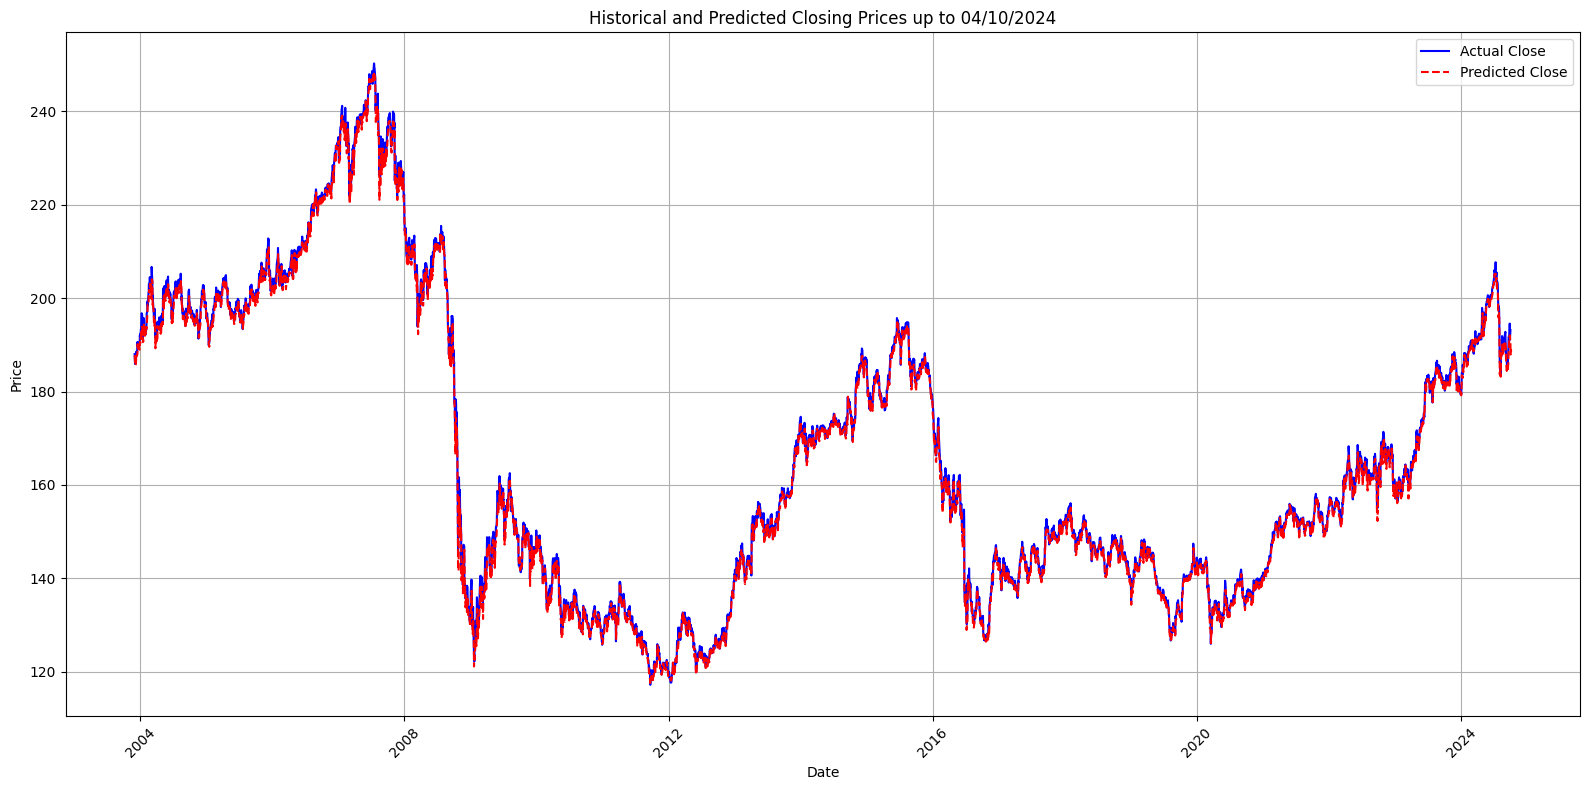

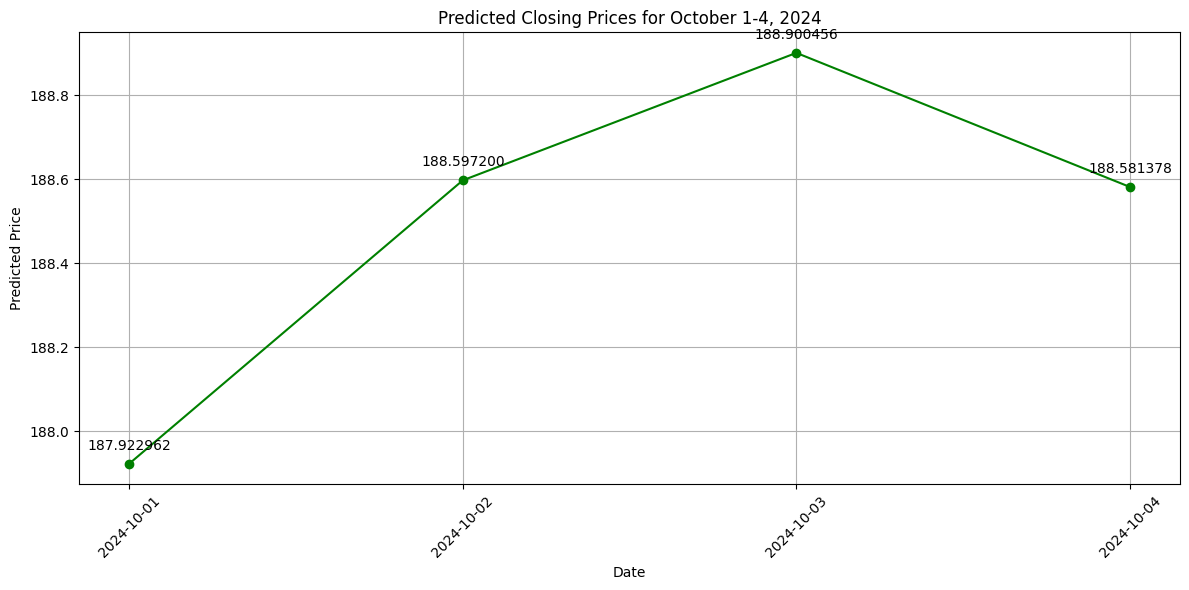


Predictions for specific dates:

Model Performance on Historical Data:
R2 Score: 0.9980752180
RMSE: 1.3622845691

Predictions saved to 'forex_predictions_to_2024-10-04.csv'


In [260]:
# **STEP 10: FINAL PREDICTION AND VISUALIZATION USING LIGHTGBM**

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import joblib
from sklearn.metrics import r2_score, mean_squared_error

# Load the trained LightGBM model from step 9
lightgbm_model = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl').best_estimator_

# Load the numerical pipeline
num_pipeline = joblib.load('models/num_pipeline.pkl')

def generate_future_features(last_data, end_date):
    days = (end_date - last_data['Date'].iloc[-1]).days
    future_dates = pd.date_range(start=last_data['Date'].iloc[-1] + timedelta(days=1), periods=days)
    
    future_data = pd.DataFrame({'Date': future_dates})
    
    # Add time-based features
    future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
    future_data['Month'] = future_data['Date'].dt.month
    future_data['Year'] = future_data['Date'].dt.year
    
    # For other features, use a simple time series forecast (e.g., moving average) with some noise
    for col in last_data.columns:
        if col not in ['Date', 'DayOfWeek', 'Month', 'Year'] + targets:
            mean_value = last_data[col].rolling(window=30).mean().iloc[-1]
            std_value = last_data[col].rolling(window=30).std().iloc[-1]
            future_data[col] = np.random.normal(mean_value, std_value * 0.1, size=len(future_data))
    
    return future_data

# Get the last data point from your original dataset
last_data = data.copy()

# Add time-based features to historical data
last_data['DayOfWeek'] = last_data['Date'].dt.dayofweek
last_data['Month'] = last_data['Date'].dt.month
last_data['Year'] = last_data['Date'].dt.year

# Set the end date for prediction
end_date = datetime(2024, 10, 4)

# Generate future features
future_data = generate_future_features(last_data, end_date)

# Combine historical and future data
combined_data = pd.concat([last_data, future_data], ignore_index=True)

# Prepare features for the entire dataset
X_combined = combined_data.drop(columns=['Date'] + targets)
X_combined = num_pipeline.transform(X_combined)

# Make predictions for the entire dataset
all_predictions = lightgbm_model.predict(X_combined)

# Add some noise to the predictions to simulate market fluctuations
noise = np.random.normal(0, 0.0005, size=len(all_predictions))
all_predictions += noise

# Create a DataFrame with all dates and predictions
prediction_df = pd.DataFrame({
    'Date': combined_data['Date'],
    'Actual_Close': combined_data['Close'],
    'Predicted_Close': all_predictions
})

# Visualize the predictions
plt.figure(figsize=(16, 8))
plt.plot(prediction_df['Date'], prediction_df['Actual_Close'], label='Actual Close', color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--')
plt.title('Historical and Predicted Closing Prices up to 04/10/2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# New plot for October 1-4, 2024
oct_data = prediction_df[(prediction_df['Date'] >= '2024-10-01') & (prediction_df['Date'] <= '2024-10-04')]

plt.figure(figsize=(12, 6))
plt.plot(oct_data['Date'], oct_data['Predicted_Close'], marker='o', linestyle='-', color='green')
plt.title('Predicted Closing Prices for October 1-4, 2024')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.xticks(oct_data['Date'], [date.strftime('%Y-%m-%d') for date in oct_data['Date']], rotation=45)
for i, price in enumerate(oct_data['Predicted_Close']):
    plt.annotate(f'{price:.6f}', (oct_data['Date'].iloc[i], price), textcoords="offset points", xytext=(0,10), ha='center')
plt.tight_layout()
plt.show()

# Print the predictions for specific dates
print("\nPredictions for specific dates:")
specific_dates = [
    datetime(2023, 12, 31),
    datetime(2024, 3, 31),
    datetime(2024, 6, 30),
    datetime(2024, 10, 1),
    datetime(2024, 10, 2),
    datetime(2024, 10, 3),
    datetime(2024, 10, 4)
]

for date in specific_dates:
    if date in prediction_df['Date'].values:
        pred = prediction_df[prediction_df['Date'] == date]['Predicted_Close'].values[0]
        print(f"{date.strftime('%Y-%m-%d')}: {pred:.10f}")

# Evaluate the model on the historical data
historical_mask = prediction_df['Actual_Close'].notna()
y_true = prediction_df.loc[historical_mask, 'Actual_Close']
y_pred = prediction_df.loc[historical_mask, 'Predicted_Close']

r2score = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\nModel Performance on Historical Data:")
print(f"R2 Score: {r2score:.10f}")
print(f"RMSE: {rmse:.10f}")

# Save predictions to CSV without rounding
prediction_df.to_csv('forex_predictions_to_2024-10-04.csv', index=False, date_format='%Y-%m-%d', float_format='%.10f')
print("\nPredictions saved to 'forex_predictions_to_2024-10-04.csv'")
